In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import nltk
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TextDataset, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback , TrainerCallback
from nltk.translate.bleu_score import sentence_bleu 
from nltk.tokenize import word_tokenize
from torch.optim import AdamW


In [41]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Terk_\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [42]:
# Set seeds
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seeds()

In [45]:
#Load File
def load_train_data(file_path):
    df = pd.read_csv(file_path)
    df['combined'] = df.apply(lambda row: f"Input: {row['word1']} {row['word2']} {row['word3']} {row['word4']} {row['word5']}\nStory: {row['story']}", axis=1)
    return df['combined'].tolist()

def load_test_data(file_path):
    df = pd.read_csv(file_path)
    return df[['word1', 'word2', 'word3', 'word4', 'word5']].values.tolist()

def load_dataset(file_path):
    return pd.read_csv(file_path)

In [56]:
#graph loss/steps
class PlottingCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.train_perplexities = []
        self.steps = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        print(f"Step: {state.global_step}")
        print(f"Loss: {logs.get('loss')}")
        print("-" * 50)
        if logs is not None and state.is_local_process_zero:
            step = state.global_step
            loss = logs.get('loss')

            if loss is not None:
                self.train_losses.append((step, loss))
            
            self.steps.append(step)

In [74]:
def generate_story(model, tokenizer, words):
    input_text = f"Words: {' '.join(words)}\nStory:"
    input_ids = tokenizer.encode(input_text, return_tensors='pt')
    
    output = model.generate(
        input_ids, 
        max_length=100, 
        num_return_sequences=1, 
        no_repeat_ngram_size=3,
        top_k=50,
        top_p=0.95,
        temperature=0.7,
        do_sample=True
    )
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    # story = generated_text.split('Story:')[-1].strip()
    story = generated_text.split('Story:')[-1].strip().replace('<|endoftext|>', '').strip()

    return story

In [62]:
#Train hyperparameters
def fine_tune_model(data):
    model = GPT2LMHeadModel.from_pretrained('gpt2')
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.pad_token = tokenizer.eos_token
    model.resize_token_embeddings(len(tokenizer))
    
    with open('temp_train_data.txt', 'w', encoding='utf-8') as f:
        for item in data:
            f.write(f"{item}\n")
    
    dataset = TextDataset(
        tokenizer=tokenizer,
        file_path="temp_train_data.txt",
        block_size=128
    )
    
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, mlm=False
    )
    
    training_args = TrainingArguments(
        output_dir="./results",
        overwrite_output_dir=True,
        num_train_epochs=4,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        save_steps=500,
        save_total_limit=2,
        eval_strategy="steps",
        eval_steps=500,
        load_best_model_at_end=True,
        logging_dir='./logs',
        logging_steps=1,  
    )
    
    optimizer = AdamW(model.parameters(), lr=5e-5)
    
    early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)
    plotting_callback = PlottingCallback()
    
    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=dataset,
        optimizers=(optimizer, None),
        callbacks=[early_stopping_callback, plotting_callback],
    )
    
    trainer.train()

    model_save_path = "./fine_tuned_model"
    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)
    
    print(f"Model and tokenizer saved to {model_save_path}")
    
    plt.figure(figsize=(15, 6))

    # Loss plot
    plt.subplot(1, 1, 1)
    if plotting_callback.train_losses:
        losses = [loss for _, loss in plotting_callback.train_losses]
        step = range(1, len(losses) + 1) 
        plt.plot(step, losses, 'b-')
        plt.title('Training Loss vs Steps')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.grid(True, linestyle='--', alpha=0.7)
    else:
        plt.text(0.5, 0.5, 'No loss data available', ha='center', va='center')

    plt.tight_layout()
    plt.savefig('training_linear_plots_batches.png')
    plt.show()
    
    return model, tokenizer

Let's go bro!


c:\Users\Terk_\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
c:\Users\Terk_\anaconda3\Lib\site-packages\transformers\data\datasets\language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


  0%|          | 0/224 [00:00<?, ?it/s]

Step: 1
Loss: 3.891
--------------------------------------------------
{'loss': 3.891, 'grad_norm': 12.082874298095703, 'learning_rate': 4.977678571428572e-05, 'epoch': 0.02}
Step: 2
Loss: 3.7069
--------------------------------------------------
{'loss': 3.7069, 'grad_norm': 9.462660789489746, 'learning_rate': 4.955357142857143e-05, 'epoch': 0.04}
Step: 3
Loss: 3.4255
--------------------------------------------------
{'loss': 3.4255, 'grad_norm': 8.552093505859375, 'learning_rate': 4.933035714285715e-05, 'epoch': 0.05}
Step: 4
Loss: 3.3027
--------------------------------------------------
{'loss': 3.3027, 'grad_norm': 8.183371543884277, 'learning_rate': 4.910714285714286e-05, 'epoch': 0.07}
Step: 5
Loss: 3.21
--------------------------------------------------
{'loss': 3.21, 'grad_norm': 7.396580696105957, 'learning_rate': 4.888392857142857e-05, 'epoch': 0.09}
Step: 6
Loss: 3.1578
--------------------------------------------------
{'loss': 3.1578, 'grad_norm': 7.60649299621582, 'lear

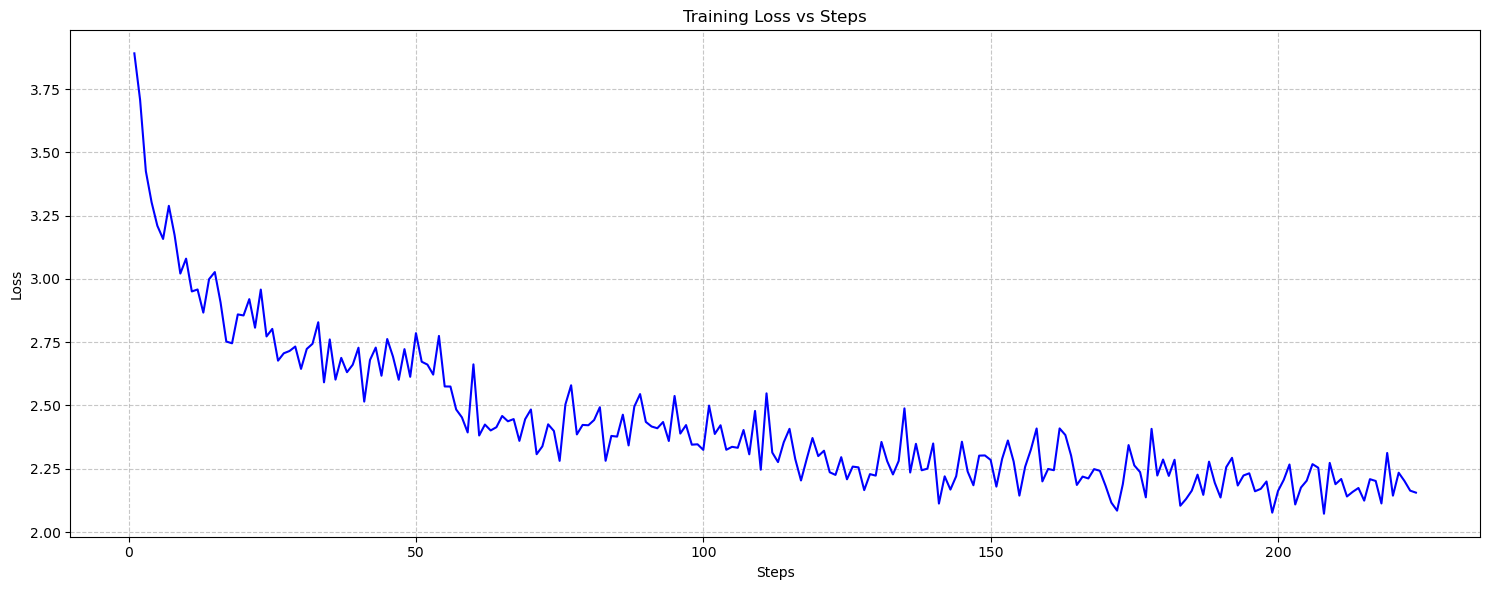

In [63]:
train_data  = load_train_data('trainset.csv')
test_data   = load_test_data('testset.csv')
dataset     = load_dataset('dataset.csv')

print("Let's go bro!")

model, tokenizer = fine_tune_model(train_data)

In [70]:
#find Bleu Score
def calculate_bleu(reference, candidate):
    reference_tokens = word_tokenize(reference.lower())
    candidate_tokens = word_tokenize(candidate.lower())
    #smoothie = SmoothingFunction().method4
    return sentence_bleu([reference_tokens], candidate_tokens) #, smoothing_function=smoothie


In [71]:
def evaluate_model(model, tokenizer, test_data, dataset):
    generated_stories = []
    bleu_scores = []
    
    for i, words in enumerate(test_data, 1):
        story = generate_story(model, tokenizer, words)
        generated_stories.append(story)
        
        matching_row = dataset[
            (dataset['word1'] == words[0]) &
            (dataset['word2'] == words[1]) &
            (dataset['word3'] == words[2]) &
            (dataset['word4'] == words[3]) &
            (dataset['word5'] == words[4])
        ]
        
        print(f"\nTest {i}:")
        print(f"Input words: {' '.join(words)}")
        print(f"Generated story: {story}")
        
        if not matching_row.empty:
            reference_story = matching_row['story'].values[0]
            bleu_score = calculate_bleu(reference_story, story)
            bleu_scores.append(bleu_score)
            print(f"Reference story: {reference_story}")
            print(f"BLEU score: {bleu_score:.4f}")
        else:
            print("Warning: No matching story found in the dataset.")
            bleu_scores.append(None)
        
        print("-" * 50)
    
    valid_bleu_scores = [score for score in bleu_scores if score is not None]
    average_bleu = np.mean(valid_bleu_scores) if valid_bleu_scores else 0
    print(f"\nAverage BLEU Score: {average_bleu:.4f}")
    print(f"Total test cases: {len(test_data)}")
    print(f"Valid BLEU scores: {len(valid_bleu_scores)}")
    
    return generated_stories, bleu_scores

In [72]:
print("Evaluating model on test set...")
generated_stories, bleu_scores = evaluate_model(model, tokenizer, test_data, dataset)

# Save results
results_df = pd.DataFrame({
    'word1': [words[0] for words in test_data],
    'word2': [words[1] for words in test_data],
    'word3': [words[2] for words in test_data],
    'word4': [words[3] for words in test_data],
    'word5': [words[4] for words in test_data],
    'generated_story': generated_stories,
    'bleu_score': bleu_scores
})
results_df.to_csv('evaluation_results.csv', index=False)
print("Save 100% Results !")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Evaluating model on test set...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 1:
Input words: attorney me parent until participant
Generated story: The attorney sat in the courtroom, ready to present evidence. The audience was captivated, and the attorney held a small, small, hand on the hot topic. He was sure that the testimony was important, as he explained the case. The attorney explained the importance of protecting the rights of the individual. The case was unique, and he knew that it could impact the outcome of the election. With each move, the audience began to feel a sense
Reference story: The attorney met with me to discuss important family matters. As a parent, I wanted to ensure that my child's best interests were prioritized. Until then, I had only been a passive participant in legal discussions, but I was ready to take an active role. The attorney patiently explained the complexities of custody agreements and the steps involved in navigating the legal system. I felt empowered to ask questions and advocate for my rights, recognizing the importa

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 2:
Input words: record however popular know television
Generated story: It was a day when viewers knew exactly what was coming. The news that the military was preparing to launch a new strategy was a big deal, but it was a reminder that the country needed a new face to unite. The audience could see that the nation was ready to face challenges, and that if they could navigate the complexities of the military's approach, they could break through the walls and become leaders.
word1: high word2: leader
Reference story: The television record ratings revealed a surprising trend; however, many viewers were unaware of the behind-the-scenes efforts that contributed to this success. Popular shows often relied on dedicated teams of writers, producers, and actors who worked tirelessly to create engaging content. Fans knew their favorite series but often overlooked the collaborative nature of television production. As the industry evolved, audiences began to appreciate the artistry involved, 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 3:
Input words: raise per night rule group
Generated story: They set a goal to raise the bar for the night. The group sought to raise awareness and create a safe environment for everyone. This effort encouraged collaboration, ensuring a safe and supportive atmosphere. The goal was to raise $1,000 to create a space where everyone could enjoy their evening.
word1: take word2: set word3: night word4: set story: The night was set for a night filled with laughter and contemplation.
Reference story: In the meeting room, a group gathered to discuss fundraising strategies to raise money for local charities. Per night, they aimed to organize events that could draw in the community, fostering a spirit of giving. They knew the rule was to create engaging experiences that would inspire generosity. Ideas ranged from charity auctions to fun runs, each designed to bring people together for a common cause. With enthusiasm and creativity, they set forth to plan events that would not only raise fu

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 4:
Input words: project he store chance amount
Generated story: In the heart of the city, the family had a hard time keeping up with their chores. They had to go to work every day, and they had to work hard to keep up. This was their first project, and it was a dream come true. However, it was clear they had missed out on the potential. The project faced deadlines, and their dreams were dashed. Their dreams were ruined, but they knew that whatever happened, they would
Reference story: He was excited about the new project at the local store, which aimed to support small businesses. They saw it as a chance to showcase local artisans and makers, bringing a fresh perspective to the shopping experience. The amount of talent in the community was staggering, and the store hoped to highlight unique products that often went unnoticed. This initiative encouraged customers to explore and appreciate the creativity surrounding them. By supporting local entrepreneurs, they hoped to foster a vi

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 5:
Input words: activity send important treat wind
Generated story: The evening sun shone brightly on the small town, as people gathered for their evening festivities. They gathered around a fire, watching the stars rise and fall, mingling with the stars. The warmth of the evening brought a sense of unity, reminding everyone that despite the darkness, they had a purpose.
word1: often word2: word3: many word4: about word5: certainly story: The story of many people who often came
Reference story: As the wind whipped through the trees, the children engaged in an outdoor activity that was both important and fun. They decided to send colorful kites soaring into the sky, treating themselves to a delightful afternoon of play. Each kite danced gracefully, painting the blue canvas above with vibrant colors. Parents watched proudly, cherishing the moments of laughter and joy. Such activities reminded everyone of the simple pleasures in life and the importance of connecting with nature, cre

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 6:
Input words: animal give billion race its
Generated story: The world's largest animal welfare organization is urging the community to support animals in their daily lives. With more than 500 million animals in the world, the animal rights organization is committed to promoting sustainable farming practices. The goal is to ensure that animals are protected from the hands of predators, ensuring they can thrive on their potential.
word1: dog word2: in word3: human word4: just word5: in story: In a world
Reference story: The documentary highlighted the plight of endangered animals, aiming to give a voice to those who could not speak for themselves. With a billion dollars allocated for conservation efforts, organizations raced against time to protect habitats and species at risk. Its impact was crucial; awareness campaigns encouraged viewers to take action in their communities. As the film unfolded, it showcased the beauty of wildlife and the urgent need for preservation. Audiences

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 7:
Input words: remember turn big walk reveal
Generated story: In the bustling city, a small town was bustling with visitors. The sun shone brightly, but it was clear that the community had grown more and more engaged with the city's struggles. With a sense of community pride, they decided to celebrate the day and make a big statement about the future. With smiles and smiles, they left the streets, ready to celebrate their past. The atmosphere was festive, with people dancing and celebrating their achievements, reminiscing
Reference story: As we remember the big moments in life, sometimes we must turn to those quiet walks in nature. Each step reveals a story, and as the trees sway, memories flood back. The importance of these reflections lies in their ability to ground us, reminding us of our roots and the journey we’ve taken. Amidst the hustle and bustle, it’s vital to find moments of peace. Whether it’s a walk alone or with loved ones, those tranquil times help clarify our thou

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 8:
Input words: accept partner adult four day
Generated story: The partner in the household had been working hard for a long time, but he couldn’t help but feel a little uneasy. The four-day work schedule was a burden on him, but his focus was on improving his physical condition and mental well-being. The day was just beginning, but the tension was palpable. The partner felt a sense of responsibility for his wellbeing, knowing that if they could work together, they could create a brighter
Reference story: As an adult, it became increasingly important to accept that partnerships require effort and understanding. The couple had four busy days ahead, filled with responsibilities and decisions. They knew that communication was key to navigating challenges together. Balancing work, personal lives, and time for each other demanded focus and dedication. Despite the chaos, they were committed to nurturing their relationship, realizing that every day presented opportunities to strengthen 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 9:
Input words: despite author realize its beat
Generated story: It wasn’t just about the money
word1: local
word2: even though they knew
word3: education word4: even word5: change story: Even though they were always in charge, even though their lives were different, their education was still a key to their success. As they learned new skills, they were inspired to adapt and embrace change.
word4: the word5 story: the story: In
Reference story: Despite facing numerous setbacks, the author continued to push through, determined to complete their novel. As the deadline approached, they began to realize the weight of their story's impact; it could resonate with many. Each character, each chapter beat with life, and the narrative flowed with honesty. The journey had been arduous, but the satisfaction of bringing their vision to life outweighed the struggles. They embraced the challenges as part of the process, knowing that their perseverance would ultimately lead to a rewarding experi

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 10:
Input words: mind past majority boy project
Generated story: The boy took the project seriously, as his project had been a success. The project team had been pushing the boundaries of academic excellence, and the team was committed to making it a reality. They had to maintain the integrity of their work, recognizing that collaboration could lead to greatness.
word1: word2: above word3: that word4: high word5: to story: The high school student stood on the high school campus, and
Reference story: In the quiet town, a boy's project aimed to explore the past through interviews with the majority of the townsfolk. His mind was set on uncovering stories that shaped their community, bringing history to life. As he listened to tales of resilience and triumph, he realized the importance of preserving these narratives for future generations. Each conversation enriched his understanding of the town's roots, weaving a tapestry of shared experiences. This project ignited a passion for sto

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 11:
Input words: continue people need side official
Generated story: In the midst of negotiations, a final agreement was reached, allowing the team to continue building upon their partnership. As they prepared to leave, they realized that their work was not only about building relationships but also about building trust. The discussions were aimed at building trust in each other, and it was clear that this was not just about making a difference but about creating a lasting connection.
word1: stop word2: about word3: by word
Reference story: As discussions continued, people began to voice their need for official policies that supported mental health initiatives. They recognized the importance of addressing these issues, not just on a personal level but as a community. With every voice added to the conversation, the momentum grew, emphasizing the need for change. On one side, advocates pushed for more resources, while officials listened intently, aware of the responsibility they he

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 12:
Input words: whom western debate life water
Generated story: The debate over the role of the water in sustainable development was lively, with many people engaging in the discussion. The discussion focused on the role the water play in ecosystem health, highlighting the importance of conserving water resources. Advocates argued that the debate highlighted the importance that environmental protection could play in promoting sustainable practices. The discussions fostered a sense of responsibility among participants, reminding them that sustainability and conservation are essential for everyone, whether they live in a
Reference story: In the western region, a heated debate arose over water rights, impacting the lives of many residents. Farmers, environmentalists, and officials gathered to discuss whom the resources truly belonged to and how they should be allocated. Life in the area depended heavily on access to water, making this issue crucial. As tensions rose, participants e

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 13:
Input words: claim say shoulder herself conference
Generated story: In the conference room, the group of executives gathered to discuss the next steps in the company's growth. The focus was on securing the best product for everyone, ensuring that every aspect of the business was aligned with their vision. The leaders discussed strategies and strategies to support their vision for the future. They discussed the challenges ahead, emphasizing that innovation was key to success. Each member shared their thoughts on how to respond to new opportunities. They focused on building
Reference story: During the conference, she made a bold claim that self-care should be a priority in today's fast-paced world. She stood confidently, sharing her journey and emphasizing the importance of prioritizing one’s well-being. As she spoke, her message resonated deeply with the audience, many of whom carried the weight of their responsibilities on their shoulders. She encouraged everyone to treat the

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 14:
Input words: father into response player case
Generated story: The father felt the importance of the outcome of the case, and decided to pursue legal action to prevent a father from losing his job.
word1: stand word2: have word3: go word4: rule word5: say story: The stand-up artist stood by his principles and made sure his work was always recognized. He had a clear understanding of the legal system and a passion for art that could make anyone laugh. He was
Reference story: Her father had always been her biggest supporter, especially when it came to his daughter's dreams of becoming a professional player. His response to her aspirations was filled with encouragement, and he often attended her games, cheering her on from the sidelines. In every case, he made an effort to be involved, believing that his presence would boost her confidence. She appreciated his unwavering belief in her potential, and this motivated her to push through challenges. With each match, she felt a deep c

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 15:
Input words: decide mother lot face take
Generated story: The family was moved to a small town, where they faced challenges and the challenges of living in a small community.
word1: she word2: her word3: no word4: need word5: one story: She was able to answer her needs, knowing that every decision she made was necessary.
words1: the word2, word3, word4, word5 story: The town was bustling with people, as everyone
Reference story: As she approached graduation, she faced a lot of decisions about her future. Her mother encouraged her to take her time and carefully consider her options. Deciding on a career path was daunting, but with her mother's guidance, she felt less overwhelmed. They spent countless evenings discussing her interests, skills, and dreams. This support helped her gain clarity on what truly mattered to her. With her mother's wisdom by her side, she embraced the unknown, ready to carve out her path in the world.
BLEU score: 0.0000
---------------------------------

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 16:
Input words: large whom wait heart career
Generated story: In a small town, a young woman named Anna was inspired by the vibrant atmosphere and beauty of the town. She loved the outdoors, and her adventures inspired her to pursue her dreams. The townspeople knew her passion, and she could do whatever she wanted.
word1: old word2: in word3: in story: In the old days, there was a small tradition of sharing stories with the community. People gathered to share stories
Reference story: In a large city where dreams often collide, she found herself waiting for an opportunity to launch her career. Whom to approach for guidance was a question that lingered in her mind. With a hopeful heart, she reached out to mentors in her field, seeking advice and support. Each conversation revealed insights that propelled her forward. She learned the importance of networking and building relationships, understanding that success often depends on the connections we make. With determination, she took

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 17:
Input words: red require will article begin
Generated story: In a world where science was a constant, it was crucial that everyone understood the importance of their contributions. They needed to understand the underlying truths of their respective fields. By the time the deadline came, everyone had made a commitment to the project, and they were eager to work on their next project.
word1: find word2: often word3: within word4: not word5: above story: In the spring of 2015, a
Reference story: The article highlighted the urgent need for action against climate change, emphasizing that red flags should not be ignored. It will require a collective effort from individuals, businesses, and governments to begin making significant changes. The authors argued that everyone has a role to play, from reducing waste to advocating for sustainable practices. With compelling statistics and real-life examples, the article aimed to inspire readers to take action. The message was clear: it is t

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 18:
Input words: apply five camera reduce lawyer
Generated story: The application process was a huge challenge. The application deadline was close, and it was time for the application process to go live. The lawyer felt like she had worked hard to get the job done, and she knew she had to make a strong case. With her team of experts, she knew that the process was tough, but she couldn’t stop until she was ready.
word1: fill word2: approach word3: piece
Reference story: She decided to apply for a position that would allow her to combine her passion for photography with her legal expertise. Five years in law school had equipped her with the skills needed to navigate complex legal matters, but her heart still belonged to the camera. She envisioned reducing barriers for artists seeking legal advice, creating a niche that blended both worlds. As a lawyer, she hoped to help creatives protect their work while also capturing their stories through her lens. This unique path reflected her 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 19:
Input words: teach foreign itself a indicate
Generated story: The language of diplomacy often found expression in the complexities of international relations. The dialogue fostered understanding, fostering trust and collaboration. By emphasizing the importance of dialogue, the teachers taught the value of dialogue and the power of empathy.
word1: every word word2: to word3: now word4: to story: Now, a new word emerged: the word5: to describe story: Today, the word to describe the event was much
Reference story: The goal of the program was to teach students about foreign cultures in a way that fostered understanding and appreciation. It aimed to indicate the importance of global awareness in today’s interconnected world. A diverse curriculum highlighted various traditions and practices, allowing students to immerse themselves in different perspectives. By engaging in discussions and projects, they learned to appreciate the beauty of diversity. This educational journey not only

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 20:
Input words: none ability mother sit much
Generated story: The mother sat by the stove while her daughter sat by her bed. The only thing she was able to do was watch the TV. It was a simple task, but it made her feel better. The baby sat quietly, waiting for the day to come.
word1: more word2: day word3: about word4: not word5: about story: The day was about to get very cold. The weather was not as bad
Reference story: Despite her mother’s initial doubts, she realized that none of her fears were insurmountable. She had the ability to overcome obstacles, even when they seemed overwhelming. Sitting down to reflect, she acknowledged how much she had grown over the years. Each challenge had shaped her resilience, teaching her valuable lessons about perseverance. Her mother’s support, though sometimes cautious, was a reminder that she was never alone in her journey. Embracing her strength, she felt empowered to pursue her dreams with confidence.
BLEU score: 0.0000
----------------

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 21:
Input words: while situation class fact design
Generated story: while waiting for the class to finish, the students gathered at the table. They were encouraged to bring their creativity and creativity to the table, showcasing their skills. The class was a showcase of creativity and skill in their respective fields.
word1: while word2: from word3: a word4: that word5: above story: With a few exceptions, the top students were above the fray. They had learned to appreciate the importance of
Reference story: While studying design, she found herself captivated by the way situations could influence a product's appeal. The class delved into the facts behind consumer behavior, revealing how emotions play a critical role in decision-making. She learned that successful designs not only meet functional needs but also resonate with users on a deeper level. This understanding inspired her to create products that tell stories and evoke feelings. By merging aesthetics with empathy, she aime

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 22:
Input words: according great black you cultural
Generated story: The music was captivating and the visuals resonated with the audience
word1: to word2: while word3: over word4: above word5: within story: while the audience was in awe they were encouraged to share their experiences
word2: as word3 word4, rather word5 story: The moment brought a sense of unity
word5: at word6: word story: As the audience sat on the edge of
Reference story: According to recent studies, there is a great need to celebrate cultural diversity, particularly within the black community. You could see the impact of representation in various industries, highlighting the importance of acknowledging and uplifting diverse voices. Festivals, art shows, and educational programs emerged as platforms for expression and connection. Communities rallied together to share their heritage, fostering pride and unity. This cultural renaissance encouraged everyone to embrace their identities, enriching the fabric of soc

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 23:
Input words: prepare one force top everybody
Generated story: In the heat of battle, a member of the military gathered to prepare for battle. Their mission was simple: to ensure that every unit was ready for the next battle. They worked tirelessly to prepare every detail for any potential threat. Their dedication to teamwork and their dedication to their mission inspired them to continue their efforts, proving once again that they were above the odds.
word1: to word2: to story: The word was coming out of
Reference story: In preparation for the upcoming event, organizers were determined to create an experience that would be a top-notch celebration. Everybody had a role to play, from volunteers to vendors, ensuring that every detail was carefully considered. They understood that it would take a force of collaboration to bring their vision to life. With passion and commitment, they worked tirelessly to coordinate activities, performances, and logistics. The collective effort ref

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 24:
Input words: attorney about recognize business population
Generated story: The attorney recognized the challenges of navigating the legal landscape in the new era of digital technology. They aimed to make a difference in the world through dialogue, creating a platform to inspire change and engagement.
word1: every word2: many word3: within word4: not word5: certainly story: Every day, the conversation about the future of the legal profession resonated with many. The attorney emphasized that individuals were empowered to shape their own
Reference story: The attorney spoke passionately about the need to recognize the evolving landscape of business in a diverse population. She emphasized the importance of inclusive practices that cater to various demographics, highlighting how diversity can drive innovation and success. By understanding the needs of different communities, businesses could create products and services that resonate with broader audiences. Her insights encouraged 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 25:
Input words: consider rest indeed administration want
Generated story: As she stood, she faced the cold air, exhausted from her recent work. Her mind was racing, and she wondered what she would find if she were to succeed in her new role. She knew the uncertainty would be present, but she had to be prepared for whatever came next.
word1: approach word2: rate word3: a word4: the word5: within story: As they approached the rate at which the world was
Reference story: As the administration proposed new policies, they urged everyone to consider the rest of the community's needs. Indeed, it was essential to strike a balance between progress and preservation. Many residents expressed their desire for change, while others wished to maintain the character of the area. The discussions that ensued emphasized the importance of collaboration and compromise. By engaging all voices in the conversation, they hoped to create solutions that would benefit everyone and preserve the unique essen

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 26:
Input words: race become political significant husband
Generated story: The marriage has been a defining moment for the couple, and today marks the culmination of that journey. As they celebrated their marriage, they felt a renewed bond, knowing that it was about creating a better future for their children.
word1: often word2: big word3: human word3,4: just word5: if story: Sometimes, it's hard to believe that human beings could live peacefully together. But it was also true
Reference story: The race for political office had become a significant event in their community, and her husband was among the candidates. She supported him wholeheartedly, understanding the importance of representation. With every campaign stop, they engaged with constituents, discussing their vision for the future. The challenges were numerous, but they faced them together, fostering a sense of unity and hope. As the election drew nearer, their efforts intensified, demonstrating their commitment to eff

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 27:
Input words: thing majority pass day low
Generated story: As the day progressed, the majority of the residents expressed their gratitude and concern for the progress made. It was a beautiful day, filled with vibrant colors and sounds. It wasn’t just about the weather, but the people’s gratitude for their community’drew in every direction. As the sun began to set, the air was warm and the people were grateful to see the progress they were making. Their sense of hope for
Reference story: One thing was clear: the majority of people were eager to pass on the knowledge they had gained over the years. Each day brought new opportunities to learn and grow, and those with low confidence often hesitated to share their insights. However, community initiatives encouraged everyone to participate, fostering a supportive environment. As stories and experiences were exchanged, a sense of camaraderie developed, enriching the lives of all involved. This collective wisdom created a ripple effec

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 28:
Input words: message add gun much mind
Generated story: The story of the gun-smuggling operation unfolded, revealing a complex system of control. The gun was a large, complex machine gun, and the execution was quick and efficient. The operation was carried out with precision, ensuring that every action was scrutinized. The audience watched as the gun was scrutinised and the operation carried on, ensuring every bullet traveled exactly the same.
word1: word2: fire word3: about word4
Reference story: The message was stark: the rising incidents involving guns demanded urgent attention. In discussions about safety, many shared how much these events weighed on their minds. Community forums were held to address concerns and brainstorm solutions. Participants felt a sense of responsibility to advocate for change, pushing for stricter regulations and educational programs about gun safety. They understood that proactive measures could lead to a safer environment for future generations,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 29:
Input words: majority choice security time apply
Generated story: As the vote came down, the majority of citizens wanted to see how the new system would protect their privacy. They organized a rally, organized by their community leaders, to voice their concerns and vote on the merits of the new law. The majority voiced their concerns, urging citizens to join them. As the debate heated up, it became clear that the majority had the right to voice opinions they wished to hear, and the pressure on the administration was palpable
Reference story: The majority of individuals faced the difficult choice between pursuing their dreams and ensuring financial security. Many felt pressured to apply for jobs that offered stability, often at the expense of their passions. Time seemed to slip away as responsibilities piled up, leaving little room for creativity. However, some began to explore ways to integrate their interests with their work, realizing that it was possible to find fulfillmen

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 30:
Input words: spend include discuss city usually
Generated story: In a bustling city, a small group gathered to discuss their experiences. The atmosphere was tense and the discussions focused on the needs of the poor and the poor. They discussed their local history and their struggles, hoping to uplift others. The meeting was a celebration of community and understanding. They shared stories about how they found meaning in the city and the challenges they faced. They embraced their differences, knowing that they could make a difference in their communities.
Reference story: In planning the city's budget, officials aimed to spend wisely, ensuring that funds would include community needs. They gathered to discuss priorities, seeking input from residents. The goal was to create a plan that would address infrastructure, education, and public safety. Each meeting was an opportunity for citizens to voice their concerns and ideas, fostering a sense of collaboration. They understood th

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 31:
Input words: together word shake bill language
Generated story: The bill was a key piece of legislation that would strengthen community institutions. It would allow for education and outreach, ensuring that everyone could benefit from the fruits of the local economy. Together, they would craft a new model for education. Together they would create a platform that fostered creativity and resilience.
word1: stand word2: in word3: now word4: trial word5: stay story: Now, the trial began. The new
Reference story: As they gathered together, the word of unity resonated among all attendees. They knew that a firm handshake was not just a greeting but a symbol of their commitment to collaboration. The bill they proposed aimed to enhance education, providing resources to teach language skills to children in need. Understanding the importance of communication in a diverse society, they were passionate about breaking down barriers. Together, they forged ahead, believing that with collecti

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 32:
Input words: room store position large staff
Generated story: In the room, it was hard not to notice a small, loyal customer waiting for a cup. The owner sat down and observed the importance of loyalty in their business. She was committed to maintaining high standards and keeping customers satisfied. Employees shared stories, showing how loyal customers felt. It was a testament to how loyal they were to their business and the community.
word1: car word2: in word3: many word4: just word
Reference story: The room was filled with excitement as the staff gathered in the store for the weekly meeting. Everyone was eager to discuss their positions and share ideas on how to improve sales. The large space allowed for an open dialogue, making it easy for everyone to contribute. Staff members brought forward suggestions on new products to stock and ways to enhance customer experience. This collaborative approach fostered a sense of community within the team, encouraging them to work tog

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 33:
Input words: sort improve short only join
Generated story: In the bustling city of New York, a woman named Sallie, a sort of middle-aged woman, began to search for a new career. Her dreams of becoming a professional were dashed, however, as she remained focused on her journey, focusing on her dreams. As she faced obstacles, she learned to navigate her way forward, guiding others toward success.
word1: buy word2: save word3: like word4: be
Reference story: They needed to sort through the feedback from their latest project to identify areas to improve. With a short timeframe to make changes, the team decided to join forces and brainstorm solutions. They focused on the most pressing issues, prioritizing which elements to tackle first. By collaborating closely, they aimed to create a more effective outcome, knowing that their combined efforts could lead to significant improvements in the final product.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 34:
Input words: increase hot benefit city bit
Generated story: In a world of globalization, the benefits of travel came first. Travel was crucial for many countries, but for those who wanted to stay longer, it was essential. The capital city was bustling with tourists, bustling with food and entertainment. The bustling streets were bustling with art and art, and the warmth of the capital hung in the air.
word1: break word2: to word3: every word4: in word5: new story
Reference story: To increase public awareness about the new recycling initiative, the city launched a hot campaign that highlighted the environmental benefits. They organized community events and distributed flyers, aiming to reach a bit more of the population each day. The goal was to encourage residents to participate actively in sustainability efforts. By showcasing success stories and offering incentives, the city hoped to create lasting change in how its citizens approached waste management.
BLEU score: 0.0000
-

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 35:
Input words: enough lay pretty above now
Generated story: The story of the new neighborhood was inspiring, with residents sharing stories about how it transformed their neighborhood. The development envisioned a new community center, with a new art gallery and a new plaza. The community felt empowered to create their own projects, and they were ready to take the next step.
word1: more word2: in word3: need word4: for word5: future story: In a bustling city, a new industry was
Reference story: They had enough resources to lay the groundwork for their new initiative, which was aimed at improving community health. The project looked pretty promising, with support from local organizations and volunteers. Above all, they understood the urgency of addressing health disparities in the area, so they decided to move forward now. The team was optimistic about making a difference in their community.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 36:
Input words: almost simple responsibility commercial during
Generated story: After a small presentation, the group decided to present a simple idea that would make the media laugh. They had to explain the importance of responsibility in the world, especially in the media landscape. They brainstormed ideas that would unite audiences and create awareness. The audience was excited, eager to hear their ideas.
word1: many word2: more word3: word4: many story: The many voices expressing their opinions often led to controversies.
Reference story: The task seemed almost too simple, but the responsibility was significant. During the commercial shoot, every detail mattered. They had to ensure that the message resonated with their audience while showcasing the product effectively. The crew worked diligently, understanding that this advertisement could impact sales dramatically. Each member played a crucial role, contributing their expertise to create a polished final product.
BLEU score

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 37:
Input words: less realize month eye light
Generated story: less realized month day
word1: word2: from word3: to word4: present word5: at story: from story: the event was about to occur at the end of the month, and it was a rare opportunity to present a new idea. They were inspired by the beautiful surroundings, the vibrant colors of the countryside, and the chance to experience a new perspective. The result was a celebration of art and culture, showcasing some
Reference story: After a month of hard work, they began to realize how much they had grown. With every challenge, they kept their eyes on the prize, motivated by the light at the end of the tunnel. They knew that less focus on minor setbacks and more attention to their progress would help them achieve their goals. This perspective shifted their approach, fostering resilience and determination within the team.
BLEU score: 0.0664
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 38:
Input words: painting easy amount picture set
Generated story: The artist took a picture of a painting and decided to go with the simple approach. He wanted to create a picture that felt more natural than the typical. He chose a simple line, focusing on detail and beauty. He created a beautiful painting, with a simple, yet beautiful, connection to the viewer.
word1: age word2: change word3: from word4: not word5: next story: The age of change in the
Reference story: Creating the mural was an easy task once they decided on the picture to paint. They agreed on a vibrant design that would resonate with the community, aiming to set a positive tone for the neighborhood. The amount of collaboration involved in bringing their vision to life strengthened their bond as a team. Each stroke of the brush represented their commitment to creating a beautiful, inspiring space.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 39:
Input words: past per everything project film
Generated story: The past perceptive team made every decision carefully, knowing that they had to execute every detail carefully. They knew that knowing their project was coming to an end would lead to a serious setback. They planned to film the final product after the deadline, but the pressure was so high, it was difficult to watch the outcome unfold.
word1: in word2: word3: for word4: head word5: how word6: in story
Reference story: Looking back at the past, they realized how much they had learned per project. Each film they produced taught them valuable lessons about storytelling and collaboration. Everything came together in the end, creating a cohesive narrative that resonated with their audience. They felt proud of their growth and were excited about the future of their creative endeavors.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 40:
Input words: interest accept much thing nearly
Generated story: The school system wasn’t perfect, but they understood the importance of education. They supported their students by taking pride in their ability to succeed, recognizing that every child deserved a chance to succeed.
word1: support word2: drive word3: experience word4: word5: student story: In the classroom, students faced challenges in their learning. Each student engaged in activities that encouraged creativity, recognizing the importance in their study. With
Reference story: Her interest in the project was evident as she accepted the challenge with enthusiasm. She understood how much effort it would take, but she was determined to make it work. The thing that motivated her most was the opportunity to learn from the experience. Nearly every moment was filled with new insights and skills that she could carry forward in her career.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 41:
Input words: leave attack smile wear seat
Generated story: As the team prepared to leave, they were reminded of the importance of teamwork. They felt empowered to act together, ensuring that their actions would not only benefit the community but also its benefit. They shared stories about how to take on challenges and adapt to the changing times. The atmosphere was tense as the team gathered, ready to tackle whatever challenges lay ahead. The team shared stories of resilience and hope, knowing they would face adversity together.
word1
Reference story: As they prepared to leave for the event, the atmosphere was charged with anticipation. They knew that the competition would be fierce, but they wore their confidence like armor. Each member of the team was determined to put their best foot forward, ready to tackle any attack from opponents. With smiles on their faces, they took their seats, ready to showcase their hard work.
BLEU score: 0.0719
-----------------------------------

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 42:
Input words: reach standard should us condition
Generated story: The standard of medical care was met with support from the community. Each member contributed their time and expertise, ensuring that every detail was taken care of. The team worked tirelessly, ensuring everyone received the highest quality care.
word1: need word2: the word3: be word4: general word5: within story: The general population was often asked to fill in the gaps in their information, often making the journey much more challenging. The
Reference story: To reach the new performance standard, the team understood that they should prioritize both training and health. They recognized that their condition would significantly impact their productivity. With this in mind, they set up regular check-ins and workshops to foster growth and well-being. Their collective effort aimed to create an environment where everyone could thrive and achieve their goals.
BLEU score: 0.0000
---------------------------------------

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 43:
Input words: prevent matter gun hold institution
Generated story: The gun hold was a common occurrence in the community, as families and others worked together to prevent gun violence. Each person was trained to protect themselves, but the importance of safety was paramount.
word1: small word2: right word3: close word4: school word5: every story: The small school in the center of town had a small classroom that sat next to the main school. Every student had a little to learn from,
Reference story: To prevent violence in the community, the institution launched a campaign focused on education and awareness. They emphasized that it mattered to address the root causes of gun violence rather than just the symptoms. By holding workshops and discussions, they aimed to foster understanding and promote peace. The initiative sought to engage citizens in meaningful conversations about safety and community well-being.
BLEU score: 0.0482
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 44:
Input words: product name three television single
Generated story: The market was divided, with many individuals seeking to find the best product. Each product had its own unique appeal, and each one had its unique challenges. The market for the new devices was growing rapidly, and the competition for the next generation of brands was fierce. The competition was fierce, and by the end of the broadcast, the competition was over. The audience was ready to spend their money on the latest gadget, and with excitement and anticipation,
Reference story: The new product launch was a significant milestone for the company, as they unveiled three innovative items designed for modern living. The television campaign aimed to showcase each product's unique features, ensuring that the name resonated with consumers. Each ad told a story, highlighting how a single item could enhance daily life. The excitement around the launch was palpable, drawing attention from various media outlets and pot

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 45:
Input words: enjoy government anyone early example
Generated story: The next day, the administration decided to take a leave of absence. They had already decided to return to school, but the excitement of the day was palpable. The administration had decided that the changes would only benefit the most fortunate students. They were determined to make sure that every student could enjoy their new school environment.
word1: the word2: outside word3: capital word4: not word5: in story: Outside the government office
Reference story: The government encouraged citizens to enjoy the benefits of the new program, which was designed to support community projects. Anyone could apply for funding, provided they met certain criteria. Early applications showcased innovative ideas, setting a great example for others. The initiative aimed to foster creativity and collaboration within neighborhoods, ultimately enhancing community ties.
BLEU score: 0.0000
----------------------------------------

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 46:
Input words: smile new production campaign real
Generated story: The new film was shot in the heart of the city, showcasing its rich history. It was a unique experience, but it was not just about the story. It became a message about the importance of community involvement.
word1: from word2: to word3: a word4: need word5: right story: The production team had to face the real-life challenges of navigating the industry. They needed to understand the importance that informed
Reference story: The new production campaign brought a smile to everyone’s face as they unveiled their latest project. The team worked tirelessly to create a real connection with their audience, focusing on authenticity and storytelling. They aimed to reflect the values of their brand while engaging viewers emotionally. This approach resonated, resulting in a campaign that left a lasting impression.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 47:
Input words: large even family agency down
Generated story: The small agency was overwhelmed with requests for help finding clients
word1: high word2: court word3: law word4: law story: The high court had issued a high court order to clear the way for the trial. The case was crucial, as it would allow the citizens to prepare for a trial that could occur in the future. The decision was greeted with excitement by the community, as the issue had been decided quickly and decisively.
Reference story: The large agency was even more committed to helping families navigate challenges. They provided resources and support to ensure that every family could thrive. Down the line, they hoped to implement more programs tailored to specific needs. This dedication to service reflected their belief in the importance of community and family well-being.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 48:
Input words: which city either black best
Generated story: In this story, the conversation turned to the city's vibrant vibrant arts scene, with many local artists emerging as potential collaborators. The discussions centered on the need to foster creativity, recognizing the need for collaboration among residents. With that in mind, the collaboration became a powerful catalyst for growth and growth, fostering a vibrant atmosphere.
word1: where word2: old word3: new word4: the word5: not story: The old town
Reference story: In which city should they host the event? They debated between two options, considering factors like location, accessibility, and the potential for attracting either a large audience or a more intimate setting. The team wanted to ensure the best experience for all attendees, regardless of the venue. Ultimately, they decided to prioritize community engagement and support for local black businesses.
BLEU score: 0.0000
-----------------------------------------

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 49:
Input words: Mrs cup together will interesting
Generated story: They spent the day together, sharing their daily dreams
word1: trial word2: to word3: be noticed word4: make word5: family story: They had a trial in which they faced the toughest test of their lives
word2: about word3 word4 word5 story: family member had come to visit them
word5: about story: She wanted to know what they thought about their family
word6: a
Reference story: Mrs. Johnson filled her cup with steaming tea as she sat down to discuss the upcoming event. Together with her committee, she planned to create an interesting lineup of activities that would engage the community. They aimed to foster connections and create lasting memories. With her leadership, everyone felt inspired to contribute their ideas and energy to make the event a success.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 50:
Input words: front support price a enter
Generated story: As the price of goods surged, many people gathered to support the latest development, hoping for a brighter future for the region. They believed that every effort needed to make a positive impact. The community rallied to the cause, believing that investing in infrastructure would bring economic growth and jobs to their region. Together, they organized events, encouraging people to support their neighbors. The event was a catalyst for a community to voice their concerns, showing that investing was not
Reference story: At the front of the store, they set up a display to support the launch of the new product. The price was competitive, ensuring that customers would find it accessible. A promotional event would encourage patrons to enter the store and explore the offerings. The excitement surrounding the launch created a buzz, drawing in foot traffic and fostering a sense of community engagement.
BLEU score: 0.0000
------

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 51:
Input words: home meet treat whatever upon
Generated story: The home of the artist was a place where friends and families gathered to share stories and memories. With a smile on their faces, they exchanged ideas, trying to figure out how to create a more harmonious environment. The artist painted vibrant colors that resonated with the community, encouraging everyone to embrace the warmth of the day.
word1: word2: make word3: a word4: a story: The story behind the art was simple
Reference story: Once they arrived home, they decided to meet and discuss their plans. They treated the gathering as an opportunity to brainstorm whatever ideas came to mind. Upon reflection, they recognized the importance of collaboration in their creative process. This meeting sparked new ideas and helped solidify their vision moving forward.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 52:
Input words: account knowledge subject college you
Generated story: In the past, the college system operated by a set of policies aimed at promoting creativity and knowledge. The goal was to foster a culture of innovation and collaboration. The school was dedicated to fostering a culture that fostered creativity and collaboration, creating a safer environment for students. The new policies aimed to foster collaboration and collaboration among students.
word1: in word2: test word3: agree word4: in story: In a crowded classroom,
Reference story: When you account for the knowledge gained in college, it becomes evident how much it shapes one’s perspective. The subject matter often extends beyond textbooks, influencing how you interact with the world. Every lesson learned builds upon the previous one, creating a foundation for future endeavors. You come to appreciate the depth of learning and its impact on personal and professional growth.
BLEU score: 0.0000
----------------------

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 53:
Input words: soon property able compare executive
Generated story: The company was ready to market its new product. It was ready for the market, and the team was ready. They aimed to market their product with a strong focus on efficiency and customer service. They knew that their efforts would lead to success, and soon, they were recognized as the leaders in the market.
word1: seven word2: senior word3: in word4: the word5: even story: The senior staff member in
Reference story: Soon after the announcement, the executive team gathered to discuss the property acquisition that could enhance their portfolio. They were able to compare various options and analyze potential returns on investment. This meeting was crucial in determining which property would best align with their strategic goals.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 54:
Input words: game final standard me reflect
Generated story: It was a final, and the result was a victory for the team. They had to face a tough situation, and they knew they had to take a shot. They couldn’t afford to lose, and this was a chance to test their resolve. They made the final, feeling proud and confident, determined to beat anyone they faced.
word1: time word2: person word3: in word4: same word5: it
Reference story: As the final game of the season approached, I took a moment to reflect on the standard we had set as a team. Every match was not just about winning but about learning and growing together. This reflection helped me appreciate the journey and the bonds we had formed along the way.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 55:
Input words: my live wrong drug should
Generated story: My partner had been diagnosed with the condition of anxiety. I knew he had a hard time coping with it, but he was determined to see a bright side. He offered me advice, encouraging me to stay calm and focus on my work. It was a simple life lesson, but now, I had to navigate the world of addiction, knowing that this treatment would teach me the hard way.
word1: too word2: word3: that
Reference story: In my community, many people live with the consequences of drug abuse, and I felt it was wrong to remain silent. We should take action, support initiatives that raise awareness, and help those affected by addiction find the resources they need to recover and rebuild their lives.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 56:
Input words: large forward carry majority you
Generated story: The long journey was a turning point for both the team and the community. They recognized the need for transparency and accountability, demonstrating a commitment to fostering a more open and accountable community. As they learned how to manage conflicts, they realized that collaboration was essential for fostering a sense of community that fostered understanding and trust.
word1: make word2: send word3: to word4: teach word5: day story: The day of instruction
Reference story: A large portion of the community was ready to move forward with the new initiative. The majority of residents supported the plan to carry out improvements in public spaces. You could feel the excitement in the air as people discussed how these changes would positively impact their daily lives.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 57:
Input words: push color peace crime administration
Generated story: The administration began work on a new initiative aimed at addressing the challenges faced by the community. Advocates sought to push for better policies and practices, focusing on education and access. They organized workshops and discussions, and organized workshops for new initiatives. By the end of the night, the administration was ready to implement the changes, demonstrating a commitment to fostering a more equitable community. The initiative sparked significant support, and the community rallied to the administration, demanding a
Reference story: The administration decided to push for policies that would promote peace and reduce crime in the city. They introduced initiatives focused on community engagement, showcasing colorful murals that represented diversity and unity. This approach aimed to foster a safer, more inclusive environment for all residents.
BLEU score: 0.0000
-----------------------------

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 58:
Input words: south not fast call treat
Generated story: The south was busy, but the call came fast and hard. The call was clear and the journey was long. The journey would take a lot of courage, but it was worth it. The town was filled with memories and memories, filled with people who worked hard, embraced their passion, and shared their joys.
word1: that word2: high word3: family word4: word5: over story: The family gathered in
Reference story: In the south, it’s not always easy to make a fast call for help during emergencies. Many communities face delays in receiving timely treatment for medical issues. Awareness campaigns were initiated to improve response times and ensure that everyone had access to quality healthcare services.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 59:
Input words: body man rule little hair
Generated story: The body was thin and the hair was not his problem. The rule was to never wash it off, and never wear it again. The doctor noticed that the hair seemed to grow thin as he worked with it, and he felt the pressure of losing it.
word1: to word2: take word3: step word4: now word5: describe story: She sat down and took a few steps toward the end of her journey.
Reference story: The body of the man lay still, a stark reminder of the rules that sometimes feel too little in the face of tragedy. Hair scattered nearby testified to the struggle, prompting a community to come together in search of justice and understanding. They vowed to address the underlying issues that led to such violence.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 60:
Input words: for game quality would station
Generated story: In a world where innovation was the norm, the team decided to innovate quickly. They focused on making the game as unique as possible. They knew that innovation and creativity could lead to lasting success.
word1: that word2: over word3: the word4: if word5: in story: The team over at the competition had to decide whether to overreact or stay focused. The players were determined to put their skills into the game
Reference story: For the upcoming game, the organizers ensured that the quality of the facilities at the station met all safety standards. They wanted to create an environment where everyone could enjoy the match comfortably. This attention to detail would help enhance the overall experience for the fans.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 61:
Input words: management build nice computer dinner
Generated story: The manager came over to discuss the latest developments, and they decided to discuss strategies for managing their team. The discussions centered on prioritizing productivity and collaboration, and the manager suggested strategies that could improve their work flow. The discussion was lively, with the focus on efficiency and innovation. The manager felt empowered to implement changes, and soon, the team was ready to take action.
word1: price word2: about word3: to word4
Reference story: The management team planned a nice dinner to celebrate their success in building the new computer systems for the office. This gathering served not only as a reward but also as a chance to strengthen team bonds and reflect on the hard work that led to their achievements.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 62:
Input words: billion woman service senior why
Generated story: The world's largest city was celebrating its billion-dollar billion-plus budget. Each year, it hosted a billion-kilometer event to give back to the community. It was a testament to the commitment of the community and its dedication to sustainability. In the spirit of collaboration, the city hosted workshops aimed to teach the importance of energy efficiency and sustainability in their initiatives. The city's commitment to sustainability was evident in its commitment to supporting local businesses and
Reference story: A billion-dollar industry has emerged focused on providing better service to senior women. The question of why this demographic has been overlooked for so long has sparked discussions on the importance of inclusivity in marketing and product development. Companies are now prioritizing the needs of older women, recognizing their purchasing power.
BLEU score: 0.0000
-------------------------------------

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 63:
Input words: try either life late score
Generated story: The evening was a bit of a test as everyone celebrated the achievements of the team. Their collaboration with the community meant they had a chance to shine, proving their mettle. They knew they had to make a difference, proving that they could pull off a big win.
word1: face word2: the word3: drive word4: market word5: 'see story: The face of the market was the driving force behind the drive
Reference story: I decided to try my best at life, realizing that I could either succeed or learn from my mistakes. Late nights spent studying and practicing were essential to achieving a good score on my exams. I understood that every effort counted, contributing to my growth and development.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 64:
Input words: dream nation oil local interesting
Generated story: The dream community in the center of the city was captivated by the vibrant oil community. The artists painted murals and brought a sense of community to the art exhibit. The community loved the natural beauty and the diverse cultures that flowed through the region, creating a sense that the region was a place of beauty and unity.
word1: town word2: over word3: family word4: dog word5: friend story: Over the years
Reference story: My dream for the nation is to transition from an oil-dependent economy to one that thrives on local resources. It’s an interesting challenge that requires innovation and collaboration across various sectors. By supporting local businesses, we can create sustainable growth and reduce our carbon footprint.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 65:
Input words: tax best huge itself draw
Generated story: In a small town, a company decided to give a huge amount of money to local charities. They decided to build a high-tech factory that would produce goods that would last for generations. The community believed that they were supporting the local economy and investing in their products. They spent countless hours crafting and evaluating their projects, believing that investing in local communities was key. This community felt empowered, as they realized that investing directly in local businesses was vital for
Reference story: The tax reform proposed was deemed the best solution for addressing the huge budget deficit. It aimed to draw in more investments while ensuring that wealth distribution was fair. The government hoped to create a system that would benefit all citizens in the long run.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 66:
Input words: real section measure simply require
Generated story: They had to test their ability to measure their performance on the final day of the competition
word1: word2: point word3: community word4: history word5: point story: They arrived in the community center, where they faced a history of discrimination. They began to question their cultural heritage, wondering what it would be to leave behind. Community leaders and community organizations came together to address the issue, creating a dialogue that would benefit everyone
Reference story: The real challenge lies in understanding how to measure success in each section of the project. We must simply identify the key performance indicators that will help us assess our progress and ensure we meet the requirements outlined at the beginning.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 67:
Input words: box law training minute because
Generated story: In a world where many were trained to navigate the complexities of law, the minute a decision was made, the matter would be settled quickly. Law students would take on the challenging legal challenges, leading to a smooth trial. With a sense of responsibility, they knew that their actions would lead to the next step in their journey. They knew that every decision was a decision, but every time they made one, it was a reflection of their hearts. They
Reference story: Inside the box lay various training materials related to law enforcement procedures. In just a minute, the team gathered around to discuss the importance of proper training, because effective law enforcement relies on well-informed officers who can navigate complex situations.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 68:
Input words: guess travel return case recent
Generated story: The guess journey returned to the hotel, where it was clear that it was time to return to the city. The return trip was a long one, but the journey was worth it. It was a chance to reconnect with friends, to hear stories of their journeys, and to experience the beauty of the natural world.
word1: car word2: mean word3: big word4: attack word5: over story: It wasn’
Reference story: I guess it’s time to travel again and return to familiar places. The recent case studies on tourism have shown how important it is for local economies. As travelers seek new experiences, the impact on communities can be significant, fostering growth and development.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 69:
Input words: campaign before office act drug
Generated story: The campaign aimed to raise funds for medical care for veterans, using campaign ads that emphasized the need for more funding for the project. The campaign aired before a major event and highlighted the importance of a strong community presence on the ground. As the campaign rolled through, volunteers gathered, eager to make a difference.
word1: be word2: the word3: now word4: lead word5: find story: Now, the campaign aimed its
Reference story: Before the office began the new campaign, they organized a meeting to discuss the impact of drug awareness initiatives. They aimed to act proactively to educate the public about the dangers of drug abuse, hoping to reduce its prevalence within the community.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 70:
Input words: own fly partner see everything
Generated story: Own the passion for fly fishing, but the love for nature brought a whole new level of adventure. As the group gathered to catch some rays, they decided to fly away from the usual routine, leaving the water to the ground. They decided to enjoy nature, knowing that every moment was precious.
word1: watch word2: stop word3: fly word4: head word5: the story: The head of the flight was watching over
Reference story: I wanted to own my journey and fly high with my ambitions. I hoped to partner with like-minded individuals who would help me see everything as an opportunity for growth. Together, we could create a network of support that propelled us all forward.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 71:
Input words: specific laugh leg offer describe
Generated story: The general manager of the company was very excited about the new product. They aimed to make it a success, with innovative features and a bold marketing strategy. It was a great opportunity to showcase their products and drive support to the community. The conversation turned to how they could improve the product and drive positive change. The manager emphasized that every product had its place in the market, and every aspect of it was a success.
word1: who word
Reference story: She had a specific way of making everyone laugh, using humor to break the ice during tense moments. When asked to describe her approach, she would offer insights into how laughter can bridge gaps and create connections among diverse groups of people.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 72:
Input words: nothing positive expert nothing skill
Generated story: The professional who reviewed the industry's latest innovations emphasized the importance of innovation, reminding everyone that nothing is guaranteed. The expert presented a detailed presentation that emphasized the value of hard work and the importance on their shoulders. It was a rare opportunity to showcase innovative ideas, highlighting the importance and importance of personal growth. It would be a testament to the dedication of the industry, as well as the commitment to innovation.
word1: a word2: to
Reference story: Despite feeling like nothing could go right, I remained positive. An expert in resilience once told me that every setback is an opportunity to develop a new skill. Embracing this mindset helped me push through challenging times and emerge stronger on the other side.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 73:
Input words: however common thousand company first
Generated story: In the middle of the night, the company's executives gathered to discuss the importance of collaboration and collaboration. The discussions sparked a sense of urgency, as executives realized that their shared goal was to create a culture that fostered collaboration and respect for all.
word1: how word2: even word3: rich word4: many word5: how story: In a bustling city, a rich culture flowed with rich cultural traditions. The rich culture
Reference story: However, it’s common for companies to face challenges when launching new products. Thousands of hours go into development, yet the first release often encounters unexpected hurdles. Learning from these experiences is crucial for future success and innovation.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 74:
Input words: difficult green season tough which
Generated story: The journey was tough as the cold hard times filled the air. The journey had been tough, but the determination to succeed was evident in the face of adversity. It was clear that they needed each other to succeed, knowing that success could only come from hard work and determination. The final drive was not just about finding success, but also about overcoming obstacles.
word1: fire word2: city word3: do word4: court word5
Reference story: It can be difficult to navigate through the green season, especially with the tough weather conditions. Which strategies should we implement to ensure our crops thrive? Discussions among farmers focused on resilience and adaptation, sharing insights to overcome challenges together.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 75:
Input words: make reduce lose pretty minute
Generated story: When they had finished, the staff gathered to discuss how to tackle the challenges ahead. They discussed strategies to reduce stress and strengthen relationships. With a renewed commitment, they brainstormed strategies that would make each member feel valued and empowered. The staff brainstormed solutions that would address the challenges they faced, recognizing that their contributions were vital to fostering a more fulfilling life.
word1: ask word2: community word3: family word4: what word
Reference story: To make the most of every minute, we must reduce distractions and focus on our goals. It's easy to lose sight of what's important when life gets busy, but taking time to appreciate the pretty moments can rejuvenate our spirits. For example, last Saturday, I decided to take a walk in the park instead of staying home glued to my screen. The flowers were blooming, and the air was fresh. I took a deep breath and fel

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 76:
Input words: surface degree whether say black
Generated story: As the sun set, they began to head for the ground, eager to see where the people were coming from. They knew that the journey would be long, and they knew that they had to adapt to the challenges faced in the world.
word1: not word2: the word3: heart word4: the story: The heart of the story unfolded as they approached the bridge, heartbroken but hopeful. They had to face the overwhelming
Reference story: The surface of the water glistened, revealing a degree of clarity that made me wonder whether I was truly seeing what lay beneath. I couldn't help but say that the beauty of the black depths was both alluring and mysterious. As I stood by the lake, I noticed the way the sunlight danced on the water, creating sparkles that seemed to whisper secrets from the depths below. My curiosity piqued, I decided to dive in. The cool water enveloped me, and as I swam deeper, I discovered vibrant fish darting among the rocks. I

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 77:
Input words: technology catch practice smile former
Generated story: The company had been working on a new product, and the team was excited about the feedback it received. They decided to implement the change quickly, and their team began to feel the benefits of the new technology. The feedback from the community was overwhelming, and they quickly found a solution that worked. The company became a leader in innovation, and it became clear that the future of the tech industry depended on it.
word1: a word2:
Reference story: With technology evolving so rapidly, it’s essential to catch up and practice new skills. A former classmate always reminded me to smile through challenges; it’s the best way to keep the learning experience enjoyable. So, I enrolled in a coding boot camp. Initially, the codes and algorithms seemed daunting, but with each passing week, I felt more confident. My classmates and I often shared our progress, and the camaraderie we built made the learning process

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 78:
Input words: art student party receive event
Generated story: As art students gathered, they gathered to celebrate the art installation on campus. They celebrated the occasion by painting their designs on a mural, highlighting their appreciation of art and the community. The event sparked a sense of belonging among students, as they recognized the significance of their art. Each artist shared their stories, sharing their passion for creating murals that reflected the beauty of life.
word1: the word2: the term word3: a word
Reference story: The art event last night brought together students from various disciplines, creating a vibrant atmosphere filled with creativity and passion. Each participant had a chance to showcase their work and receive feedback from peers and mentors alike. The highlight of the evening was a collaborative mural that many contributed to, symbolizing unity among different artistic styles. The party atmosphere made it easier to connect and share creative

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 79:
Input words: Republican care skill condition western
Generated story: Republican health care system, particularly in the western portion of the state, highlighted a significant issue affecting the health of the community. As more people sought medical care, concerns about rising costs mounted, with many residents feeling the brunt. As the discussions unfolded, residents expressed concern about the future of their health and their options. The conversation turned to the issue of healthcare reform, and it became clear that the Republican administration was determined to make a positive impact on the
Reference story: In the Republican debate last night, candidates emphasized the need to care for the people by showcasing their skill sets. They discussed the condition of the western states, highlighting the challenges faced by residents there. Issues like drought and economic decline were at the forefront of the discussions. One candidate proposed innovative solutions aimed at rev

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 80:
Input words: physical speech on value health
Generated story: When the doctor asked if she could speak for the first time, she couldn’t help but smile. She knew that words could not describe the journey she had made, and the smile that followed made her feel a sense of purpose.
word1: old word2: business word3: type word4: a word5: from story: During the recent wave of growth in the industry, it was clear that the old-fashioned type
Reference story: During our school's physical education class, we had a speech on the value of maintaining health through exercise. The instructor highlighted how our daily activities can significantly impact our overall well-being and longevity. We discussed various forms of exercise, from sports to yoga, and their benefits for both body and mind. Inspired by the session, many of us formed a workout group, meeting after school to encourage one another. We not only became healthier but also strengthened our friendships, proving that good health ca

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 81:
Input words: region general actually partner structure
Generated story: In the midst of a difficult negotiation, the team decided to work together to create a strong partner that could stand alongside the needs of the community. The collaboration fostered trust and innovation, proving that collaboration can make a lasting impact on the region.
word1: new word2: new story word3: even word4: even story: In recent years, the industry has grown to become even more competitive, with new and innovative products being introduced
Reference story: In this region, the general structure of the economy is actually shifting due to the influx of technology startups. Local businesses have begun to partner with larger corporations to boost growth and development. This collaboration aims to create a more resilient economic landscape. Entrepreneurs and established businesses alike are investing in community resources, providing training and mentorship to aspiring business owners. I attended a 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 82:
Input words: blood few news quality eat
Generated story: In a bustling market, the bloodthirsty crowd awaited news on the latest news, eager to eat the delicacy. The crowd was filled with anticipation as the meal was ready, with the anticipation palpable. The price of fresh produce had risen, prompting a few to sell their bags before the deadline. The buzz of the market was palpable as the food became available. The vendor's reputation was undeniable, and the price of the product was a testament to
Reference story: The news about the quality of food we eat has gained traction, especially with few people aware of its impact on blood health. In a recent health fair, nutritionists provided information on how certain diets can affect blood pressure and overall wellness. Attendees were encouraged to sample healthy snacks and learn how to read nutrition labels. The event aimed to educate the community on making informed dietary choices. I learned about the benefits of incorporating

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 83:
Input words: draw together social manager strategy
Generated story: The team was in the thick of brainstorming ideas, ready to tackle anything. They brainstormed ways to make the community more active, and the collaborative spirit encouraged creativity. As the brainstorming sessions progressed, they realized that creating a vibrant environment for creativity could create lasting impact, and they began to brainstorm ideas that would resonate with the community. By the end of the brainstorm, they had a plan to bring the community together, and their commitment to collaboration
Reference story: To draw people together, the social manager proposed a new strategy that focused on community engagement. This approach aimed to build stronger connections among residents, fostering a sense of belonging and collaboration. During the town hall meeting, various initiatives were discussed, from community gardens to cultural festivals. I was particularly excited about the idea of a monthly p

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 84:
Input words: between my travel PM west
Generated story: the west was bustling with excitement as they arrived for the next leg of their trip. As they crossed the beautiful countryside, they felt a deep sense of camaraderie. They knew the journey would be a journey ahead, and they were ready to make the most of it.
word1: from word2: from story: from west word3: within word4: east word5: within story: Within the heart of the city,
Reference story: Between my travels to the west and my experiences with various cultures, I've learned so much about the world. During a recent PM meeting, I shared insights on the importance of cultural exchange in fostering understanding and cooperation. My travels had taken me to vibrant markets and serene landscapes, each encounter teaching me about the richness of diversity. As I spoke, I saw nods of agreement and interest from my colleagues. We discussed potential initiatives to promote cultural appreciation within our community, and I left the

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 85:
Input words: ok before serious cultural reduce
Generated story: The audience was ready to relax and enjoy the festivities. The focus on entertainment was evident, as the audience eagerly awaited the new film. As the film began, it was clear that the audience was excited about the stories behind the film. The anticipation was palpable, as they eagerly awaited its release date.
word1: word2: from word3: seven word4: just word5: fast story: In the fast-paced city, a
Reference story: It's ok to have fun before addressing serious matters, but we must recognize the importance of cultural sensitivity to reduce misunderstandings. A recent workshop highlighted this topic, encouraging participants to engage in thoughtful discussions about cultural differences. We shared personal experiences and learned about various traditions, which fostered empathy and understanding. By the end of the session, many attendees expressed a desire to implement what they learned into their daily lives, pr

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 86:
Input words: then he space option live
Generated story: He knew he was in a position to make a difference in the world.
word1: small word2: approach word3: not word4: more word5: soon story: When he arrived, he felt a sense of urgency in his decision to leave the city. He wasn't sure how to manage the situation, but he knew it was worth the effort. He decided to remain at the city center, making sure to implement his vision
Reference story: Then he explained the concept of personal space and why it’s important. During a workshop on communication skills, we discussed how respecting boundaries enhances relationships. We also talked about the option to live comfortably in our own bubble and how it can affect interactions with others, especially in crowded environments. The facilitator encouraged us to practice expressing our needs while being mindful of others. By the end of the session, I felt empowered to communicate better and respect the personal space of those around me.
BL

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 87:
Input words: environmental nothing off spring central
Generated story: The town was bustling with activity as residents gathered for their annual harvest. As they gathered, the sun shone brightly, and the trees grew thick. As the season approached, everyone was ready for a feast. It was a celebration of nature, but with a sense of peace in their hearts.
word1: ten word2: seven word3: day word4: different word5: human story: In the bustling city, everyone gathered to enjoy
Reference story: The environmental report indicated that nothing was off the table when it came to spring initiatives aimed at conservation. Central to the discussion was the need for sustainable practices in our daily lives. Community leaders gathered to brainstorm ways to promote awareness and encourage action. We discussed organizing clean-up days, planting trees, and educational workshops. By the end of the meeting, there was a shared sense of purpose, knowing that every small action could contribute to 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 88:
Input words: list hear wear other produce
Generated story: In the kitchen, the kitchen conversation was full of food items. The team brainstormed ways to keep their kitchen clean and organized. The goal was to keep the food simple, to keep everyone happy. The food was made simple, with simple ingredients. Each dish was carefully chosen to complement the food. The result was a meal that was rich in nutrients and nutrients.
word1: do word2: stay word3: small word4: fish
Reference story: I decided to list the things I need to accomplish this week, as I often hear that organization is key to productivity. Each item on my list represented a task I needed to tackle, from grocery shopping to preparing for a meeting. As I wore my favorite sweater, I felt motivated to take on the day. I also remembered to produce quality work, ensuring that I wouldn’t rush through anything just to check it off my list. By the end of the week, I realized that having a clear plan helped me achieve more 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 89:
Input words: seek pass president beautiful in
Generated story: The president of the United States, the first president of his time, was honored in the capital of the world. His speech was a celebration of history, a reminder of the power of perseverance and dedication to the cause. His message resonated with the heart of the nation, reminding them of the strength of unity and perseverance. He spoke with a sense of purpose, reminding everyone that perseverance was essential in navigating challenging times.
word1
Reference story: In an effort to seek solutions to the ongoing issues in our community, we held a meeting with the president. It was a beautiful day, and we gathered in the park to discuss ways to enhance our local environment. The president was enthusiastic about hearing our ideas, emphasizing the importance of community involvement. As we brainstormed initiatives, it became clear that working together could lead to significant improvements in our area. In the end, we

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 90:
Input words: reality language enter visit you
Generated story: The world is changing, but it's not just about the color of the sky
word1: dog word2: place word3: dog story: The dog was the place to be when you were gone
word4: dog language: dog talk story: A dog was a crucial part of life
word5: dog meaning story: At the dog store, a new product was coming online
word6: human word story: As the
Reference story: In reality, learning a new language can be challenging, but it’s also incredibly rewarding. When you enter a conversation with someone who speaks that language, it opens doors to new cultures and experiences. Recently, I had the chance to visit a foreign country, and being able to speak even a little of the local language transformed my experience. I discovered that language is not just about words; it’s about connecting with people on a deeper level, sharing stories and laughter that transcend barriers.
BLEU score: 0.0000
----------------------------------------------

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 91:
Input words: power itself agent late shoulder
Generated story: As the story unfolded, she felt the weight of responsibility weighing heavily on her shoulders. She had to face the consequences of her actions, and she knew that the world was in her best interests. With a stroke of a pen, she decided to take charge, and the pressure was off. As she left the room, she realized her mission was clear: to change the world, and inspire others to follow suit.
word1: word2:
Reference story: The power of positive thinking can change your life; it’s a concept that speaks for itself. However, it’s easy to forget this when things get tough. I often feel late to the party when it comes to self-care, as responsibilities pile up. One day, I decided to give myself a break and focus on what truly matters. I called a friend, an agent of positivity, who reminded me to lighten my load. With her words of encouragement, I lifted the weight from my shoulder and embraced the day with a fresh perspecti

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 92:
Input words: run near life throw sea
Generated story: As the run was about to begin, she began to worry about the consequences of her decision. The air was heavy with excitement as she watched as the water ran out of control and the run continued on her path.
word1: that word2: the word3: that story: The run ended at the ocean
word4: the words word5: every word6: if story: During the final moments of the race, the sun
Reference story: To run along the beach near my home is one of my favorite ways to clear my mind. The sound of the waves crashing against the shore brings a sense of peace to my life. One day, as I threw a pebble into the sea, I watched the ripples expand, reminding me of how small actions can create larger effects. This simple ritual became a metaphor for my daily life; every decision I made could impact not only me but also those around me. It was a powerful realization that guided my choices moving forward.
BLEU score: 0.0000
---------------------------------

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 93:
Input words: under use may your meet
Generated story: The meeting was a success. They discussed the importance of innovation and collaboration, emphasizing the importance and importance of fostering a culture of collaboration and collaboration. They shared insights on how to increase the number of participants, ensuring that collaboration was a priority for every member. The atmosphere was palpable, and everyone had a good time.
word1: business word2: over word3: mean word4: in word5: take story: In a recent meeting
Reference story: Under the bright lights of the conference room, I prepared to use my presentation skills to convey our project’s vision. I knew that this meeting could be pivotal for our team, as it may lead to crucial partnerships. As I glanced around, I saw familiar faces and hoped to meet their expectations. Each participant had their own ideas, and I encouraged collaboration, knowing that together, we could achieve greatness. The energy in the room was palpab

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 94:
Input words: from door citizen figure significant
Generated story: As she sat in the small room, her mind filled with thoughts of the future. Each letter she read illustrated her journey, reminding her of the importance of perseverance in life. Each word was a reminder of the challenges she faced as a young woman. With each letter, she understood that nothing could ever be done that would compromise her life.
word1: it word2: left word3: different word4: the word5: they
Reference story: From the moment I walked through the door, I felt the warmth of community spirit. As a citizen of this vibrant town, I often reflect on how each individual can figure into the larger picture. During a recent town hall meeting, we discussed significant changes coming to our neighborhood, and everyone was encouraged to voice their opinions. It was refreshing to see so many people passionate about the future of our community. Together, we are shaping the path ahead, ensuring that everyone’s voice

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 95:
Input words: put involve none relationship a
Generated story: The girl was ready to embrace the challenges of life and career. She was confident that she could overcome obstacles, knowing that the love and support she had brought would ultimately shape her. Her journey was filled with hope, and with determination, she would succeed.
word1: they word2: big word3: word4: to word5: well story: They had a big meeting, discussing how to make a big impact in the industry.
Reference story: To put effort into building relationships is essential, especially when it comes to involving others in your journey. None of us can achieve our goals alone; it’s a collective effort. I reached out to my friends, sharing my aspirations and inviting them to be a part of my journey. We discussed our dreams and how we could support each other along the way. This openness not only strengthened our bonds but also fostered a sense of accountability. It was a beautiful reminder that we thrive together.
B

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 96:
Input words: fine crime worry guess response
Generated story: The crime was too serious to prevent, but the team came up short. The team had to focus on catching the culprits, ensuring they were safe. The tension rose as the crime rate soared, and the team began to prepare for the next attack.
word1: in word2: within word3: a word4: they word5: very story: Within a few minutes, the conversation shifted from one about crime to another, and
Reference story: It’s fine to worry about crime in our communities, but it’s essential to approach the issue with a proactive mindset. I guess it’s easy to become overwhelmed, but in our last neighborhood meeting, we discussed effective responses to enhance safety. Residents shared ideas ranging from neighborhood watch programs to community clean-ups. It was inspiring to see everyone come together, determined to create a safe environment for our families. By taking action, we turned our worries into a powerful force for positive change.
BLEU

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 97:
Input words: along ready determine floor condition
Generated story: In a chaotic room, the manager decided to close the door, and the room began to tense. Everyone was waiting for the manager to calm the situation down. As they worked, they noticed a pattern emerging, revealing the potential for chaos. The manager had instructed the team to stay calm, knowing that chaos would happen as they worked together. The tension of the situation made it hard to focus on the best way forward, but the manager believed in his
Reference story: Along the journey of self-improvement, it’s vital to be ready for challenges. Determining the right path often requires stepping out of your comfort zone. I remember a day when I decided to tackle the messy condition of my workspace. The clutter on the floor had been distracting me, preventing me from focusing. With determination, I spent the afternoon organizing and decluttering. Once I was finished, I felt a wave of relief and clarity wash over me,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 98:
Input words: compare Republican huge fill range
Generated story: As the party rose, they shared ideas on policy and strategy. They shared common ground on how to balance the needs of the people and serve the interests of the majority. The atmosphere of excitement was palpable as they brainstormed solutions. The debate flowed freely, and the discussions were focused on their shared values.
word1: within word2: many word3: if word4: in word5: local story: Within the community, a local
Reference story: In the political landscape, we often compare the Republican party to other groups to understand their influence. Recently, there was a huge turnout at a town hall meeting where citizens came to fill the seats and voice their concerns. A range of issues was discussed, from healthcare to education. It was invigorating to witness such engagement and passion among community members. The enthusiasm reminded me of the power we hold as citizens to influence change and advocate for the is

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 99:
Input words: them fill notice use type
Generated story: The company had planned to launch a new product, but it had trouble scaling the market. With a tough market, the team decided to focus on product innovation. They wanted to make it as easy as possible while still maintaining the commitment to delivering high quality products. They decided to build a team that could make the best decisions.
word1: do word2: the word3: the story: The team had already done everything they could to make
Reference story: To fill the gaps in our understanding of community needs, we must notice what is missing and take action. I decided to use a new approach to gather feedback from residents on what type of services they felt were lacking. Through surveys and informal discussions, I learned about various concerns, from mental health support to recreational activities. It was eye-opening to see how different perspectives can shape our community initiatives, and I felt a renewed commitment to add

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 100:
Input words: represent yourself inside I south
Generated story: The city of Aspinia was transformed into a thriving market with vibrant food and art showcasing its artistic heritage. I visited the bustling market, showcasing the vibrant art and cultural heritage. The artisans showcased their creations in vibrant displays, while locals celebrated the beauty of their surroundings. The atmosphere was captivating, as everyone took part in the festivities. The community embraced the art, while the artist showcased his creativity in their displays. The vibrant atmosphere inspired everyone
Reference story: To truly represent yourself, you must be authentic and genuine. Inside, I often reflect on my journey and the experiences that have shaped me. As I traveled south for a family reunion, I embraced my roots and shared stories with my relatives. These moments reminded me of the importance of family and connection. Each story we shared was a thread weaving us together, reinforcing th

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 101:
Input words: raise activity teacher answer catch
Generated story: As the teacher took a break, she learned that she needed to keep the focus on creativity and teamwork. She needed to reflect on her role in creating a supportive environment. She shared the story with friends, reminding them that it wasn’t just about pushing boundaries, it was about finding the best way to make the most of life.
word1: word2: throw word3: fall word4: word5: word story: The
Reference story: As a teacher, I aim to raise awareness about the importance of physical activity in students' lives. During a recent health class, I posed a question to my students, hoping to catch their interest. ‘What do you think is the best way to stay active?’ I was delighted by their enthusiastic responses, ranging from team sports to dancing. It was clear that they understood the value of movement. By facilitating discussions around physical activity, I encouraged them to make healthy choices and prioritize their wel

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 102:
Input words: tonight perform beautiful simply husband
Generated story: We all know what it takes to be a rock star. As the evening drew to a close, we realized that our lives would be transformed. We would sing, sing, and celebrate the beauty of the land. Each act was a testament to the power of song and the power it could hold. With these memories in our hearts, we knew that our journey would be different. Together, we could create new memories and challenges that would benefit everyone.
Reference story: Tonight, I will perform at the local theater, and I can’t help but feel excited. The beautiful script tells a heartfelt story of love and sacrifice, and I’m grateful for the opportunity to bring it to life. Simply being on stage allows me to express emotions and connect with the audience. As I look over at my husband in the front row, I feel a rush of support and encouragement. His presence reminds me that art has the power to resonate with people, and I can’t wait to share

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 103:
Input words: culture be role tree dog
Generated story: The role of culture in the community was to foster a sense of belonging and respect for others. The role was to ensure that everyone felt valued and respected. It was essential that everyone feel valued and supported in their decision-making process. The dog was a symbol of loyalty, and the commitment to the community resonated deeply with the community.
word1: word2: do word3: not word4: day word5: sound story:
Reference story: Culture plays a significant role in shaping our identities, much like a tree that provides shelter and sustenance. It represents our roots and branches out into various aspects of life. I often reflect on how my upbringing and experiences have influenced my perception of the world around me. Having a dog as a companion has also enriched my life, as it embodies loyalty and unconditional love, reminding me of the importance of connection and companionship in our cultural experiences.
BLEU score: 0.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 104:
Input words: day avoid agreement surface no
Generated story: The agreement was clear, but the tension was palpable. The negotiations had been tense, but now they were ready for the final word. The agreement had been made, but it was too late. The tension was now palpable, and it was time to head out for the finish line. The pressure was palpable, but nothing less. The final word would be spoken, and the final decision was likely to be made in the next few days.
word
Reference story: Every day, I strive to avoid negativity and cultivate a positive mindset. I made an agreement with myself to focus on what truly matters and to let go of the surface-level distractions that often pull me away from my goals. There are days when it’s easy to lose sight of this commitment, but I remind myself that it’s okay to say no to things that don’t align with my values. Embracing this mindset has helped me to live authentically and prioritize my well-being.
BLEU score: 0.0000
-----------------

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 105:
Input words: center there form mention effect
Generated story: In the center of the room was a computer room where various ideas were discussed. The center was divided into four sections, each with its own unique features. The discussions centered around the upcoming release of new features, and the collaborative atmosphere was infectious.
word1: different word2: the word3: human word4: as word5: always story: As the word was spoken, the human being was reminded of the human connection. They had
Reference story: At the center of every successful project lies a clear vision. There’s a specific form that outlines the objectives and strategies we need to implement to achieve our goals. I often mention the importance of communication within a team, as it has a profound effect on our ability to collaborate effectively. When everyone is aligned and shares their ideas, the outcome is far more successful, making the entire process rewarding and fulfilling.
BLEU score: 0.0000
-------

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 106:
Input words: detail of water drive language
Generated story: As the wind blew through the sky, the moment of calm settled over the table. The moment of truth arrived quickly, as the sun reflected the color of the ocean. The atmosphere was beautiful, as it reflected the beauty of life in the community. The warmth in the air was palpable, as they held hands and listened to the stories shared by others. The conversation flowed freely, with laughter and understanding.
word1: return word2: dog
Reference story: The detail of our environment often goes unnoticed, much like the water we drink every day. It’s vital for life, yet we frequently take it for granted. I’ve learned to drive deeper into my understanding of the language of nature, appreciating the intricate balance that exists in our ecosystems. This awareness inspires me to protect our planet and encourages others to respect the natural resources that sustain us all.
BLEU score: 0.0000
--------------------------------------

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 107:
Input words: senior key computer then time
Generated story: The computer was not in the right place. As they began to write the code, they were reminded of the importance of ensuring their work was done within the legal system. They aimed to create a safe environment that would allow them to express themselves freely, knowing that it was their duty to ensure that their work did not get in the way.
word1: senior word2: job word3: right word4: just word5: story:
Reference story: As a senior in college, I realize that time is of the essence. The key to success lies in how we manage it, especially when it comes to completing assignments and balancing extracurricular activities. I often find myself in front of my computer, juggling multiple responsibilities. It’s essential to prioritize tasks and allocate time wisely, as this approach not only enhances productivity but also fosters personal growth and well-being.
BLEU score: 0.0000
------------------------------------------------

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 108:
Input words: evidence plant way south natural
Generated story: In a beautiful garden, a garden bloom bloomed. The flowers were a reminder of the beauty of nature and the connection between it and the natural world. The plants grew from seeds planted in the ground, reminding everyone that gardens could be a source of nourishment. The gardeners gathered around their favorite flower, sharing stories about the beauty and fragility of nature. They shared stories about their loved ones growing up in this beautiful environment, inspiring others to
Reference story: There is evidence to suggest that connecting with nature can improve our mental health. Planting trees and caring for our environment can create a positive impact on our communities, particularly in the southern regions where natural resources are under threat. I’ve found that taking time to appreciate the beauty of nature has a profound way of grounding me and providing clarity in my busy life. Engaging with the environm

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 109:
Input words: fact stuff well production science
Generated story: The fact that they had a big project that was ready for launch meant that they knew they had to act fast to ensure that the product could meet their vision. The team worked tirelessly to ensure their products met their expectations, and the anticipation was palpable. The excitement had been palpable for quite some time, but it was finally time to get the word out, and launch their product. With a bang, the team showcased their product, showcasing a unique approach
Reference story: It’s a fact that science has revolutionized our understanding of the world. The stuff we learn in classrooms and laboratories allows us to explore the intricacies of life and the universe. I find joy in discussing scientific production with my peers, as it leads to meaningful conversations about innovation and discovery. By fostering curiosity and critical thinking, we can contribute to a future where knowledge empowers us to tackle t

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 110:
Input words: fight agency production consider movement
Generated story: As the company moved into the new era, their marketing strategy became clear. They aimed to create a strong image that resonated with their loyal customers. They focused on delivering a solid product with a solid user experience. Their vision was to bring excitement to their entire team, ensuring that every detail was considered. As they worked tirelessly to achieve that goal, they became known for their commitment to quality and success.
word1: change word2: within
Reference story: In the fight for social justice, every agency plays a vital role in driving production and change. It’s essential to consider the movements that have come before us, learning from their successes and failures. By standing together and advocating for our rights, we can create a society where everyone is treated fairly. This collective effort strengthens our resolve and fuels the passion for creating a better future for generat

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 111:
Input words: realize cell message indeed church
Generated story: The church was full of people, each with unique needs. The emphasis was on supporting each other and their families. The atmosphere was festive and filled with laughter, reminding everyone of the importance of unity and unity. It was a place where everyone felt supported, supported and inspired.
word1: to word2: teach word3: make word4: drive word5: too story: To teach people how to drive was a huge challenge, but
Reference story: As I began to realize the impact of community on personal growth, I understood that each cell in our society contributes to the larger message we send. Indeed, places like the church serve as gathering points where individuals unite to share their experiences and support one another. These connections help us navigate life’s challenges, reminding us of the importance of belonging and community in our journeys.
BLEU score: 0.0482
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 112:
Input words: high drive future few suggest
Generated story: The story was interesting, but it was a bit overblown. The world was on the verge of a new era, but the excitement was palpable as the new administration took over. The excitement was contagious, and the potential for a brighter future was palpable.
word1: heart word2: big word3: about word4: on word5: officer story: On a major street, the officer was a big heart, eager to help.
Reference story: The high aspirations we set for ourselves often drive our future success. A few months ago, I took a leap of faith and decided to pursue my passion for writing. I suggest that everyone explore their dreams, no matter how daunting they may seem. By embracing our passions and staying committed, we can carve out a path that leads to fulfillment and happiness. This journey may not always be easy, but the rewards are worth the effort.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 113:
Input words: require radio instead bad at
Generated story: In the middle of the night, they decided to listen to the radio. They decided to let it speak for themselves instead of worrying about what they had to say. They sat down, enjoying the moment, knowing that they had finally found peace in their lives.
word1: in word2: word3: from word4: too word5: for story: The conversation was tense, but the tension in the room was palpable.
Word
Reference story: Certain projects require a level of commitment that can feel overwhelming. Instead of succumbing to the pressure, I often tune into the radio for inspiration and motivation. There are times when I feel bad about not meeting my own expectations, but I remind myself that progress is not linear. By focusing on small wins and staying positive, I can keep moving forward, even when the going gets tough.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 114:
Input words: be mission mean go most
Generated story: As the mission approached, they faced a difficult decision. The mission required significant planning, but they knew that doing it would mean significant impact. They decided to focus on creating a meaningful impact story that resonated with everyone. As they prepared to engage audiences, they began to feel empowered to tell their story. It was a reminder of the importance of self-expression and personal growth, and the power of change.
word1: be word2:
Reference story: To be truly fulfilled in life, I believe it’s crucial to have a mission that resonates with your values. What does it mean to pursue this mission? For me, it’s about taking actionable steps towards my goals and not letting fear hold me back. Most importantly, it’s about finding joy in the journey and embracing the lessons learned along the way. As I continue to grow and evolve, I remain committed to living my mission every day.
BLEU score: 0.0000
---------

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 115:
Input words: truth after relate fund century
Generated story: The fund was created to support charities across the country, with a vision to transform their future. It had a mission to provide the best possible support to those in need. With its dedication and dedication, it was able to support over 1.5 million people.
word1: how word2: where word3: in word4: all word5: family story: In the heart of the community, where families gathered, they realized that everything
Reference story: The truth often reveals itself in unexpected ways, especially after we take the time to reflect on our experiences. In this century, it’s crucial to relate our personal stories to the larger narrative of humanity. By sharing our journeys, we can help fund initiatives that promote understanding and connection among diverse communities. This approach not only fosters empathy but also strengthens the bonds that unite us as a society.
BLEU score: 0.0000
---------------------------------------------

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 116:
Input words: could already state and position
Generated story: The city was bustling with activity, with everyone from farmers to artists to artists enjoying their work. The festival showcased local art and activities, showcasing vibrant arts and traditions. The atmosphere was festive and bustling, with vendors and vendors selling their wares. Visitors could enjoy the festival's festivities, as they gathered to enjoy the festivities.
word1: sit word2: out word3: take word4: send word5: be story: The atmosphere
Reference story: We could achieve so much more if we already embraced the potential within us. It’s essential to state our intentions clearly and take action to move forward. In this competitive world, standing in our position of strength allows us to shine. By believing in ourselves and supporting one another, we can create an environment where everyone can thrive and succeed together.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 117:
Input words: less day without get on
Generated story: The day was tough for the community, with many families struggling to make ends meet. The family had to make sacrifices, but there was always a sense of hope and accomplishment to come. With the help of friends and family, they came together to enjoy the moment.
word1: old word2: all word3: same word4: sound word5: a story: In the old town, a story flowed freely, filled with stories of
Reference story: In our fast-paced lives, we often feel less connected to ourselves and to each other. Each day seems to blur into the next, especially when we try to get everything done on time. Without taking a moment to pause and reflect, we can lose sight of our priorities and what truly matters. It’s essential to find time to breathe and recharge, allowing us to appreciate the journey we’re on rather than just rushing through it.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 118:
Input words: environment mind challenge lead meet
Generated story: The room filled with excitement as attendees gathered to discuss the upcoming exhibition. Attendees discussed the importance of creativity in their lives, while emphasizing that collaboration between artisans and designers could empower their communities. The goal was to create a vibrant community that would foster creativity and creativity. The community embraced the idea of community, embracing each other's differences in ways that fostered collaboration and creativity across boundaries.
word1: air word2: fly word3:
Reference story: The environment around us significantly influences our state of mind. We face numerous challenges daily, but how we respond to them can lead to growth and resilience. It’s important to meet these challenges head-on, as they often serve as catalysts for change. Embracing a positive mindset enables us to view obstacles as opportunities rather than setbacks.
BLEU score: 0.0000
----

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 119:
Input words: thank would strong human knowledge
Generated story: The teacher had taught the students how to overcome obstacles with a strong sense of purpose. They knew they would succeed in school and in life, but they needed stronger support and encouragement.
word1: mean word2: we word3: heart word4: many word5: and they had many reasons for saying they were mean story: The heart of the school was often filled with heartache, but the students were determined to express their emotions in
Reference story: I would like to take a moment to thank those who have supported me in my journey. It takes a strong community of human beings to uplift each other and foster an environment of growth. Knowledge is power, and sharing what we know can strengthen our bonds and create a lasting impact. Together, we can achieve great things and make a difference in the lives of those around us.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 120:
Input words: alone that where production research
Generated story: The industry landscape shifted, but the focus remained on innovation
word1: only word2: attack word3: sound word4: word5: crime story: In response to the news, the crime scene was quickly identified as the culprit. The artist had only just left the stage, and the sound of gunshots echoed throughout the area. The city was calm, and everyone knew the crime was under control. The artists had chosen to focus on the
Reference story: While I often enjoy spending time alone, I recognize that collaboration can lead to incredible outcomes. That’s where the magic happens—when diverse minds come together to share ideas and push the boundaries of production and research. Working alongside others can open new doors and lead to discoveries we may never have made on our own.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 121:
Input words: thousand about what son letter
Generated story: The letter was meant to convey the message of hope and unity. It was written with a simple message: We all share the same dream and strength. The letter illustrated the journey of hope, reminding everyone that life and its struggles are part of who we are.
word1: face word2: place word3: just word4: yes word5: they word story: They faced a similar situation but couldn’t face the thought of
Reference story: A thousand thoughts can race through our minds when we think about our loved ones. What does it mean to be a parent or a child? I often write letters to my son, expressing my hopes and dreams for him. These letters serve as a testament to my love and the values I want to instill in him as he grows. Each word carries weight, shaping his understanding of the world.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 122:
Input words: city matter type everyone attention
Generated story: In a city where history was lost, the community gathered to hear the story of the city's changing landscape. The spirit of growth was evident, reminding everyone of the importance of community engagement. The community rallied, recognizing that change was not just about money but about values. Local businesses thrived, and the community rallied to advocate for a new kind of economy that would foster a vibrant future. The effort to create a thriving economy, while recognizing the importance
Reference story: In a bustling city, it can feel like everything moves at lightning speed. It matters how we choose to engage with our surroundings and the people within them. Every type of interaction holds the potential to foster connections or create barriers. It’s crucial for everyone to pay attention to the little moments that can make a significant difference in our lives.
BLEU score: 0.0000
---------------------------

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 123:
Input words: while tell each single article
Generated story: In the bustling city, the stories of life were told through the windows. People shared stories and stories shared about their experiences, hoping to share them in a meaningful way. The local newspaper had a wide audience, allowing readers to share their experiences. They aimed to inspire readers to reflect on their struggles and the lessons they learned from their journeys.
word1: the word2: many word3: there word4: man word5: a story
Reference story: While I read every single article I come across, some resonate more than others. I love to tell stories, weaving together facts and personal anecdotes to engage my readers. Each piece becomes an opportunity to connect, share knowledge, and inspire others to think critically about the world around them. Storytelling is a powerful tool that transcends boundaries.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 124:
Input words: money computer continue bar old
Generated story: The old computer had been sitting in the old room for too long, making a mess of the old files. The old woman was demanding more, and her efforts to restore the computer were proving to be a life-changing event. The computer was a disaster, and now it was time for her to save it.
word1: buy word2: from word3: company word4: big word5: product story: With a big product
Reference story: In today’s digital age, money often feels tied to technology. The computer has transformed how we manage our finances, but it’s important not to lose sight of traditional values. We continue to face challenges that bar us from achieving financial security, especially for the older generations who might struggle with adapting to these changes. It’s crucial to find a balance between modern tools and time-tested practices.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 125:
Input words: want structure network case her
Generated story: The new structure in the network meant she could focus on her needs while still maintaining her connection with her roots. With a simple smile, she navigated the hurdles ahead, ensuring that she could maintain her connections with the community and the law.
word1: family word2: it word3: kind word4: city word5: a story: The family felt a sense of responsibility for their journey. They were not just a family, but
Reference story: In our quest for success, we often want a clear structure to guide us. Building a strong network can help us navigate the complexities of our careers and personal lives. In every case, I’ve found that genuine connections make all the difference. It’s essential to support each other, especially when life throws curveballs. I appreciate her unwavering belief in the power of collaboration.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 126:
Input words: door state society front hour
Generated story: The city hall was filled with people coming to enjoy the city's cultural traditions, including art, music, and art. People gathered to hear the stories behind the scenes, and a sense of unity emerged among the participants. People shared stories of stories shared by artists, and laughter filled the air as they shared their experiences. Attendees were encouraged to reflect and appreciate their surroundings, fostering a sense that this place was truly theirs.
word1: new
Reference story: Every door we open leads to new possibilities. We have the power to state our beliefs and advocate for change in society. Standing at the front of movements that promote justice and equality takes courage and dedication. In just one hour, we can make a difference by engaging in conversations and actions that challenge the status quo.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 127:
Input words: many success nature whether arm
Generated story: In the spring, she decided to wear a lot of colors to her daily routine. She felt inspired, leading everyone to recognize her beauty. With a sense of humor, she transformed her routine into a celebration of her work. Her bright colors inspired everyone to embrace her beauty and her creativity.
word1: person word2: high word3: time word4: well word5: that story: The meeting was lively, with discussions about science
Reference story: Many people seek success without considering the importance of balance. Nature often reminds us of the interconnectedness of all things, and whether we realize it or not, our actions have far-reaching effects. We must nurture our environment and our relationships, much like we would tend to an arm of a tree. Growth takes time and patience, but the rewards are well worth the effort.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 128:
Input words: foot chance section future because
Generated story: The future was bright, but the future was uncertain. The moment of clarity was fleeting, but they were still committed to their mission. They knew that by pursuing their dreams, they would face challenges head-on.
word1: lead word2: well word3: law word4: only word5: a story: As the law was written, the story of the lead lawyer turned into a familiar one. He stood quietly, and the
Reference story: Every step we take is a chance to shape our future. By choosing to be proactive and engaged, we can influence the sections of life that matter most to us. It’s essential to act with purpose because the path ahead is often uncertain. Embracing opportunities as they come allows us to grow and learn, forging our unique journey.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 129:
Input words: degree number ready take your
Generated story: The degree of preparation was key to success in the workplace, as students gathered to discuss their options for future projects. The students shared stories about the challenges they faced, recognizing that perseverance alone could mean the difference between success and failure. As they brainstormed solutions, their collective mind was filled with hope and determination. The discussions sparked deep bonds, reminding them of their potential and their responsibility as a team.
word1: service word2: ready
Reference story: A degree can open many doors, but it’s your determination that truly defines your success. Knowing the number of challenges ahead can be daunting, but being ready to take on those challenges is what sets achievers apart. As you navigate your path, remember to trust in your abilities and stay focused on your goals.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 130:
Input words: one us form college carry
Generated story: The teacher asked us to imagine the future, reminding us that we could make a difference in our classrooms. Each piece of advice would inspire us, allowing us to build a deeper understanding of the world. By the end of the discussion, everyone had the power to change their lives, inspiring them to reflect on the importance of education.
word1: be word2: for word3: to word4: not word5: see story: In
Reference story: One of the most valuable lessons I’ve learned in college is the importance of community. Us forming connections with our peers allows us to carry each other through tough times. Collaboration and support are vital in achieving our goals. We grow together, and the experiences we share shape our futures in ways we may not yet understand.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 131:
Input words: go wonder strategy fill a
Generated story: The journey of the journey had a significant impact on their lives, and they knew that their journey had been shaped by the journey. They learned to love the journey, knowing that every moment was a chance to change the direction of their lives.
word1: a word2: no word3: just word4: in word5: about story: In a world that often relied on word games, no one knew exactly how to describe the latest
Reference story: In life, we often go through phases where we wonder about our purpose. Creating a strategy to fill our days with meaningful activities is essential. A balanced approach to living can lead to a more fulfilling life. It's about setting goals and pursuing them with determination.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 132:
Input words: ten within how health act
Generated story: The doctor emphasized the importance of taking a positive approach to treatment. The message resonated with the patients and their families, reminding them that their actions could have a profound impact on their lives.
word1: time word2: not word3: small word4: to word5: officer story: An officer stationed outside the city was busy working on a small operation. He was not ready for the heavy work ahead. The small operation would not
Reference story: In ten years, I wonder how my life will look. Within that time, I aim to prioritize my health and well-being. It’s crucial to act on our intentions now, as they shape our future. Making small changes today can lead to significant benefits down the road.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 133:
Input words: TV return six him surface
Generated story: The return of the world's best TV team was evident on the screens of the new generation. The team would return to the studio, ready to deliver the latest news and insights. They were confident that their work would resonate with viewers, reminding them that success lies in the eyes of the viewer.
word1: return word2: return story: The team returned to the stage after a year of hard work. The return was short-lived,
Reference story: After a long day, I love to unwind in front of the TV. It's my way to return to a sense of normalcy after a hectic week. Six episodes of my favorite show can easily make time fly. The stories often make me reflect on deeper themes just beneath the surface.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 134:
Input words: member someone single whom marriage
Generated story: As they left the kitchen, someone asked her to come with them. They knew she wanted to share her journey with others. They embraced the idea of sharing stories and supporting each other, ensuring that the journey was a journey worth celebrating.
word1: family word2: see word3: well word4: the word5: friend story: The family gathered in the living room, watching the news unfold. It was a time when they had
Reference story: Being a member of a community is important, as it provides support and connection. When someone asks about my thoughts on marriage, I often share my views on partnership and companionship. It’s a single journey filled with shared experiences and growth with someone whom you cherish.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 135:
Input words: step example religious sell prepare
Generated story: The family gathered to sell their home, eager to support their loved one, while their beliefs were reflected in the community. They understood that the church was a family gathering place, where they could learn about their family's history and traditions. The atmosphere was warm, and everyone felt inspired by the community's traditions.
word1: find word2: not word3: it word4: many word5: maybe story: Maybe, maybe, the
Reference story: Every step we take in life can serve as an example to others. I believe that our actions, whether religious or secular, can impact those around us. If we prepare ourselves to sell our ideas passionately, we can inspire change in our communities.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 136:
Input words: away your since close guess
Generated story: In a calm atmosphere, a teacher decided to teach her students a new skill, but the teacher didn’t expect them to learn anything new. With a smile, they learned to relax and appreciate the moment.
word1: within word2: different word3: maybe word4: do word5: not story: In the bustling city center, there was a different type of community to the one in the center of the city. They
Reference story: It’s easy to drift away from what matters most in life. Your priorities might shift since life constantly evolves. It’s essential to stay close to those who matter and not just guess what they need. Open communication is the key to lasting relationships.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 137:
Input words: meet act mention tell open
Generated story: The open-air meeting room was filled with people talking about the future of the area. The atmosphere was lively and welcoming, as participants shared stories about their experiences with the community. The dialogue focused on the importance of community engagement and collaboration in shaping the future. Openness encouraged conversation and shared ideas, allowing attendees to create a positive environment that fostered understanding.
word1: get word2: word3: on word4: attack word5
Reference story: When we meet new people, it’s important to act genuinely and authentically. I often mention my hobbies to spark interesting conversations. I believe that if you tell your story openly, it encourages others to do the same.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 138:
Input words: sense forget get Mrs they
Generated story: The family was on a short trip to visit the town. They had arrived late for the summer vacation, but they had a hard time keeping their distance. As they walked the streets, they felt a sense of security around them.
word1: feel word2: just word3: everyone word4: see word5: in story: The atmosphere in the city was just as beautiful as the air.
words1: as word2 word
Reference story: Sometimes, we may forget to appreciate the little things in life. It makes sense to slow down and enjoy each moment. Whether it’s a conversation with Mrs. Smith or a smile from a stranger, they all contribute to the beauty of our days.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 139:
Input words: cause entire step central majority
Generated story: The cause of the crisis was clear in the middle of the street. The city hall building had been under attack for months, with people running and screaming for help. The manager, who had run a business for over a decade, faced the crisis head-on. The workers had lost everything, and his heart was pounding.
word1: every word word2: all word3: for word4: they word5: before story: As
Reference story: The cause we fight for often defines our journey. The entire process of advocating for change is a series of steps that leads us to a more just world. The central issue may seem daunting, but the majority of us can make a significant impact when we come together.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 140:
Input words: all subject cup show billion
Generated story: Every topic was discussed. The audience was fed the truth about their favorite cup designs, and every topic resonated with their heart. The conversation flowed smoothly, allowing everyone to relate, and the audience enjoyed the shared their favorite moments. The cup show was a celebration of creativity, where the participants shared their ideas and challenges, creating a lasting piece of art.
word1: they word2: if word3: they thought word4: in word
Reference story: In our vast universe, we find all kinds of subjects to explore. Each cup of coffee I sip while reading expands my understanding of the world. I sometimes think about how billions of people are living their lives, each with unique stories to tell.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 141:
Input words: investment sure sell smile base
Generated story: The bold statement by the investment firm sparked a lively debate about the benefits and risks of a bold investment plan. With a bold plan, the community rallied behind it, believing that investing in innovation was crucial to the future of our industry. The investment community rallied around the vision, eager to see the investment in the area of innovation and sustainable growth.
word1: out word2: a word3: they word4: left word5: it
Reference story: Investment in ourselves is the best gift we can give. I’m sure that when we learn to sell our skills confidently, we can make a mark. A genuine smile can be the base of building connections that last a lifetime.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 142:
Input words: safe check rate into however
Generated story: The new guidelines could lead to a significant decrease in the rate of hospitalization for the population. By the end of the year, the rate was expected to drop below the level it was today, leaving patients with a significant need for care. In the city, residents often found it difficult to navigate the halls of hospital settings, frustrated by the constant phone calls from patients. The new regulations would help balance this tension, allowing patients to make informed decisions about
Reference story: Feeling safe in our environments is vital. It's important to check in with ourselves and others regularly. We often rate our experiences, but we should remember to dive deeper into what truly matters. However, it’s equally crucial to recognize the beauty in simplicity.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 143:
Input words: book close of customer cold
Generated story: The book was the last word on the call. It was a story about a new book that had been published, but had yet to be published.
word1: new word2: place word3: picture word4: even word5: just story: The new model was a new model, a little bit different from what they had been doing. They had just launched a new product, and it was time to take that leap.
Reference story: A good book can transport us to different worlds. I love to close my eyes and imagine the stories unfolding. Each page offers a glimpse of life through the eyes of the characters. As a customer, I appreciate the art of storytelling, especially when it makes me feel cold and lonely.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 144:
Input words: operation usually receive theory start
Generated story: As the operation progressed, it became clear that the research was likely to yield results, leading to breakthroughs in the field. The team worked tirelessly to keep the findings to a minimum. With each step of the process, they were rewarded with new insights and ideas that would lead to meaningful results.
word1: teach word2: time word3: time story: The classroom was full of lessons. Teachers gathered to teach the latest concepts, ensuring
Reference story: Every operation in life usually requires careful planning and execution. We receive many theories on how to live better lives, but it’s the practical steps we take that truly matter. To start living fully, we must apply what we learn and make adjustments along the way.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 145:
Input words: four reflect each fine often
Generated story: The story of a family's favorite meal was the highlight of the dinner, especially when they gathered to eat. The family enjoyed the fresh flavors and the memories of the past. They would often bring their meals to the table, ensuring that everyone enjoyed the meal. Each member of the family was grateful for the food and the attention to detail, knowing that their efforts would not only benefit the health of the community but the future of their community.
word
Reference story: There are four key lessons I’ve learned that I often reflect on. Each experience, whether good or bad, teaches us something valuable. It’s fine to make mistakes; they’re part of our growth. Often, we need to remind ourselves that progress takes time and patience.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 146:
Input words: brother man beat spring population
Generated story: As the boy was beating the spring, the neighbors knew that their brother was a brother, and they would always remember their brother's accomplishments. The brother had never been as fierce as the other, but they knew that once they were together, they would bond over the past decade.
word1: season word2: small word3: dog word4: word5: season story: In the small town, a small dog had just been left
Reference story: In the heart of the city, my brother and I often go for long walks, discussing everything under the spring sun. We talk about the changing population dynamics, the beat of the urban life, and the sounds of nature that often go unnoticed in our bustling world.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 147:
Input words: which sound voice soldier international
Generated story: As the war was over, the world was watching the impact on the minds of the world. The nation was divided, and many felt the loss of their nation. The local leaders had a strong message, and they rallied to bring clarity and hope to their community. The tension between peace and war was palpable, as they worked to bring awareness and peace to the nation. As the day wore on, it became clear that the stakes were high, and
Reference story: The sound of a soldier's voice often carries a heavy weight, echoing through the hearts of those who listen. In international discussions, these voices highlight the need for peace and understanding across nations, resonating deeply with the call for unity.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 148:
Input words: police mission skin against career
Generated story: The mission to achieve the mission was to create a safer environment for employees. The mission was simple: To protect employees and to empower them to succeed. The community rallied, demonstrating their support for the initiatives. As the community rallied together, the police force quickly developed into a symbol of unity, leading to a sense of community pride. The response was swift, and police officers fought crime, demonstrating the value of teamwork and perseverance.
word1:
Reference story: A police officer has a mission to protect and serve, often putting themselves against the dangers of the world. Their career demands resilience and strength, navigating through complex societal issues that impact communities of all skin colors.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 149:
Input words: stuff international theory car training
Generated story: With the race to the finish line, the local community gathered to share their experiences. The atmosphere was tense, but the excitement was contagious. The excitement was palpable, and the participants shared their stories. The event was the perfect opportunity for locals to see the beauty of their surroundings, inspiring them to pursue their dreams.
word1: a word2: a story word3: within word4: in word5: change story: Within a community
Reference story: When it comes to international relations, the theory behind diplomacy is as complex as the mechanics of a car. Just as a vehicle needs proper training to run smoothly, nations must learn to navigate their relationships effectively.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 150:
Input words: nature gun onto film magazine
Generated story: The film was shot in the same time as the local premiere, and its cast were divided. As the audience celebrated the release, they wondered how it would affect their lives. The film captured the essence of nature in a way that made it feel like a festival. It was a celebration of nature, showcasing the beauty of the world that had been lost. The actors wore their hearts out, knowing that their performance would resonate with the audience.
word
Reference story: A film can capture the essence of nature in ways that a magazine cannot. Yet, both mediums often portray the stark realities of life, including the troubling presence of a gun in a world that should celebrate peace and harmony.
BLEU score: 0.0606
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 151:
Input words: to weight by community success
Generated story: The community was engaged in discussions about how to make a difference in the workplace. The goal was to make it fairer, and they organized workshops for the younger generations. The atmosphere was electric, as the participants shared ideas and strategies. The community embraced collaboration, recognizing that by embracing differences, they could make a significant difference in their lives.
word1: community word2: time word3: education word4: day word5: not story
Reference story: To achieve success, we often carry the weight of our community's expectations. It can be overwhelming at times, but the support we receive helps us navigate our paths and turn dreams into reality.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 152:
Input words: wife allow matter all Congress
Generated story: In the kitchen, a woman decided to give her husband a chance to rest. As she listened to the husband's voice, she felt a sense of responsibility for his safety. His efforts were appreciated, and she understood the importance of their shared responsibilities.
word1: make word2: for word3: a word4: for story: The wife of the late senator, Martha Stewart, was a talented writer. She contributed valuable perspectives to her
Reference story: In a marriage, it’s essential to allow space for each partner’s dreams to flourish. It’s a matter of mutual respect that extends beyond the home and can influence even larger institutions like Congress, where voices of many come together.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 153:
Input words: part heavy program information car
Generated story: The company was working hard to keep its new model of electric cars from being a threat. They had to create a special program to showcase the latest models. By the time the doors opened, they were ready to share the success with the community. The team had created a high-tech platform that would allow consumers to drive the latest products in a real-time environment. The focus was on safety, ensuring that every car was equipped with the latest technology
Reference story: Part of understanding the complexities of our society involves sifting through heavy information. Whether it's a car's specifications or a government program, the details matter and shape our views on progress.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 154:
Input words: down despite office either only
Generated story: The story: They decided to down the elevator in the office but decided to put down their plans rather than risk it. It was a common practice for employees to go down the hall rather than go down to the desk. The decision was a calculated one, and it made sense for them to stay down.
word1: up word2: within word3: member word4: student word5: outside story: In a quiet room, students
Reference story: Despite the challenges we face, it's important to keep our heads held high, even when the office seems overwhelming. Either we choose to rise above or let the stress bring us down, but the decision lies solely with us.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 155:
Input words: his event focus necessary exist
Generated story: His speech was a success, turning attendees into enthusiastic participants. They had to ask the right questions, especially about his vision for the future. He emphasized the importance of listening to the needs of the community, emphasizing that everyone could contribute. The event was a testament to his commitment to creating a thriving city. Attendees felt empowered to connect with the people, sharing stories and ideas that resonated deeply.
word1: every word word2: a
Reference story: His focus during events is admirable; it’s necessary to remain present and engaged. In a world where distractions abound, simply existing in the moment can sometimes feel like a radical act.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 156:
Input words: money floor certain future reduce
Generated story: The business had always been a bit of a challenge. It needed to balance its investment with the needs of customers. With the help of its staff, the business was able to meet its needs with ease. As the year went by, it was able, through hard times, to maintain its balance. The employees worked tirelessly, ensuring that their jobs were filled with the creativity they deserved.
word1: spend word2: five word3: over
Reference story: Managing money wisely is crucial for securing a certain future. It’s essential to keep our finances grounded, ensuring we don't let them weigh us down to the floor but instead invest in opportunities that uplift us.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 157:
Input words: member really society spend tend
Generated story: The society needs to balance their values and interests, but they need to balance the benefits and risks involved. By focusing on the importance of fostering a fairer society, the researchers found that the community could benefit from fostering a more open atmosphere.
word1: include word2: in word3: job word4: business word5: in story: In the job market, the industry is known for its innovative solutions. As the industry expanded,
Reference story: Being a member of society means we really need to understand our roles. We tend to spend our time debating what makes a good citizen, yet often forget that our actions define us more than our words.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 158:
Input words: stay amount smile sign performance
Generated story: The audience was excited about the performance of the show and the impact they had on the company. The performances were memorable, demonstrating the value of their talent and dedication. Attendees were impressed with the talent displayed, highlighting their commitment to making a positive impact in their community.
word1: within word2: just word3: family word4: same word5: drive story: Within a family of seven, a drive to drive was just as
Reference story: To stay positive, we must focus on the amount of joy we can bring to others. A simple smile can be a sign of hope in a world that often overlooks the beauty in small performances of kindness.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 159:
Input words: continue understand arm approach early
Generated story: The arm approach allowed the group to engage in more effective strategies. Their strategy emphasized that they would keep their focus on the goals they had set. As they practiced their approach, their strategies became more effective, allowing them to continue their journey.
word1: act word2: that word3: every word4: spend word5: find story: The act of spending money on personal items was a source of stress for many. Every step in
Reference story: To continue growing, we must understand the importance of an open arm approach, welcoming new ideas early on. The willingness to embrace change is what drives progress and innovation.
BLEU score: 0.0000
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Test 160:
Input words: attention character painting box range
Generated story: The character behind the character art was a popular character in the art market. The artist captured the moment with passion and enthusiasm, prompting the audience to experience the art as a representation of the character. The art illustrated the character's journey through his family, reflecting his journey. The audience became captivated, captivated by the attention to detail that captivated them.
word1: dog word2: many word3: in word4: the word
Reference story: In art, attention to detail can transform a simple painting into a powerful narrative. Each character within it tells a story that goes beyond the confines of a box, illustrating a range of human experiences and emotions.
BLEU score: 0.0000
--------------------------------------------------

Test 161:
Input words: child relationship tax leader in
Generated story: As the leader of the family business, she launched a successful campaign to raise a

In [75]:
def check_words_in_story(words, story):
    missing_words = [word for word in words if word.lower() not in story.lower()]
    return missing_words

user_input = input("Please enter 5 words: ")
words = user_input.split()
if len(words) != 5:
    print("Please enter exactly 5 words.")
missing_words = words.copy()  

attempts = 0
max_attempts = 5  
        
while len(missing_words) > 2 and attempts < max_attempts:
    story = generate_story(model, tokenizer, words)
    missing_words = check_words_in_story(words, story)
            
    if len(missing_words) <= 2:
        print("\nInput words:", ' '.join(words))
        print("\nGenerated story:")
        print(story)
        if missing_words:
            print(f"\nNote: The word(s) '{', '.join(missing_words)}' are not in the story.")
            break
    else:
        print(f"\nAttempt {attempts + 1}: Missing words: {', '.join(missing_words)}")
        print("Generating a new story...")
        attempts += 1
        
    if attempts == max_attempts:
        print("\nFailed to generate a story with 3 or more words after multiple attempts.")
        print("Last generated story:")
        print(story)
        print(f"Missing words: {', '.join(missing_words)}")



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Input words: kill hammer human face eye

Generated story:
The hammer was a reminder of the importance of human life and the importance in the world. The human eye would be wiped from the landscape, but it remained calm as they watched the fierce hammer fall. The head of the team prepared to face the challenges head on, but they knew they would face whatever came next.
word1: stop word2: word3: in word4: over word5: the story: In the end, the

Note: The word(s) 'kill' are not in the story.
